In [ ]:
#install.packages("rsample")
#install.packages("h2o")
#install.packages('AmesHousing')
#install.packages('ggpubr')
#install.packages('vip')
#install.packages("e1071")

In [ ]:
#install.packages('IRkernel')
#IRkernel::installspec()  # to register the kernel in the current R installation


In [1]:
options(repr.plot.width  = 15,
        repr.plot.height = 10)

In [2]:
set.seed(123)

# Import libraries

In [3]:
library(AmesHousing)

# Helper packages
library(dplyr)     # for data manipulation
library(ggplot2)   # for awesome graphics
require(gridExtra) # for make subplot 
library(ggpubr)    # for make subplot and more
library(vip)

# Modeling process packages
library(rsample)   # for resampling procedures
library(caret)     # for resampling and model training
library(h2o)       # for resampling and model training
library(recipes)  # for feature engineering tasks


# h2o set-up 
h2o.no_progress()  # turn off h2o progress bars
h2o.init()         # launch h2o


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi


Loading required package: lattice


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 days 9 hours 
    H2O cluster timezone:       America/Montevideo 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.1.3 
    H2O cluster version age:    14 days, 4 hours and 43 minutes  
    H2O cluster name:           H2O_started_from_R_creyesp_osn291 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.24 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



# Regression

## Load Dataset

In [4]:
# Ames housing data
ames <- AmesHousing::make_ames()
ames.h2o <- as.h2o(ames)
head(ames)

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


## Data Splitting

In [ ]:
?createDataPartition

In [5]:
# Using base R
set.seed(123)  # for reproducibility
index_1 <- sample(1:nrow(ames), round(nrow(ames) * 0.7))
train_base <- ames[index_1, ]
test_base  <- ames[-index_1, ]

# Using caret package
index_2 <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE, )
train_caret <- ames[index_2, ]
test_caret  <- ames[-index_2, ]

# Using rsample package
split_1  <- initial_split(ames, prop = 0.7, strata = Sale_Price)
train_rsample  <- training(split_1)
test_rsample   <- testing(split_1)

# Using h2o package
split_2 <- h2o.splitFrame(ames.h2o, ratios = 0.7, 
                          seed = 123)
train_h2o <- split_2[[1]]
test_h2o  <- split_2[[2]]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


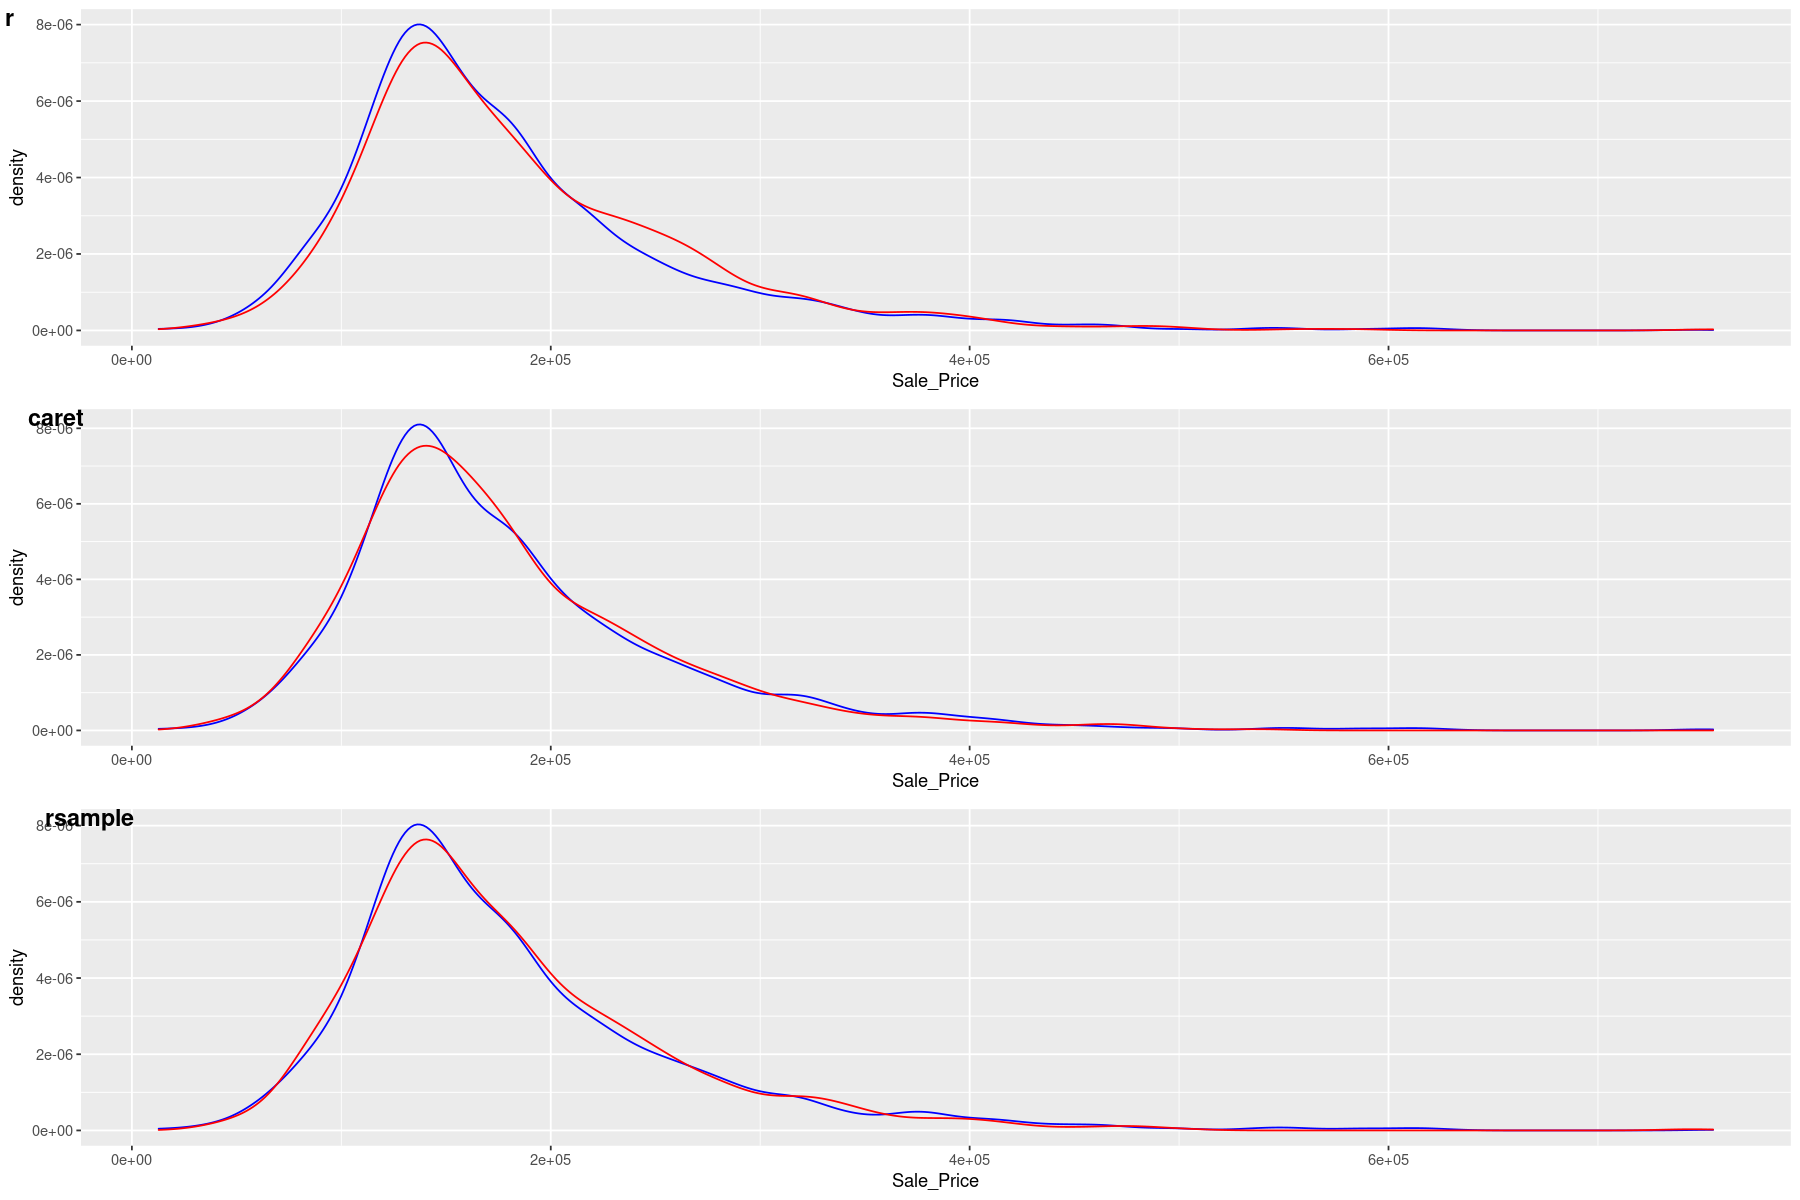

In [6]:
fig1 <- ggplot() + 
    geom_density(data=train_base, aes(Sale_Price), color='blue') + 
    geom_density(data=test_base, aes(Sale_Price), color='red')

fig2 <- ggplot() + 
    geom_density(data=train_caret, aes(Sale_Price), color='blue') + 
    geom_density(data=test_caret, aes(Sale_Price), color='red')

fig3 <- ggplot() + 
    geom_density(data=train_rsample, aes(Sale_Price), color='blue') + 
    geom_density(data=test_rsample, aes(Sale_Price), color='red')

ggarrange(fig1, fig2, fig3, labels = c("r", "caret", "rsample"), ncol = 1, nrow = 3)

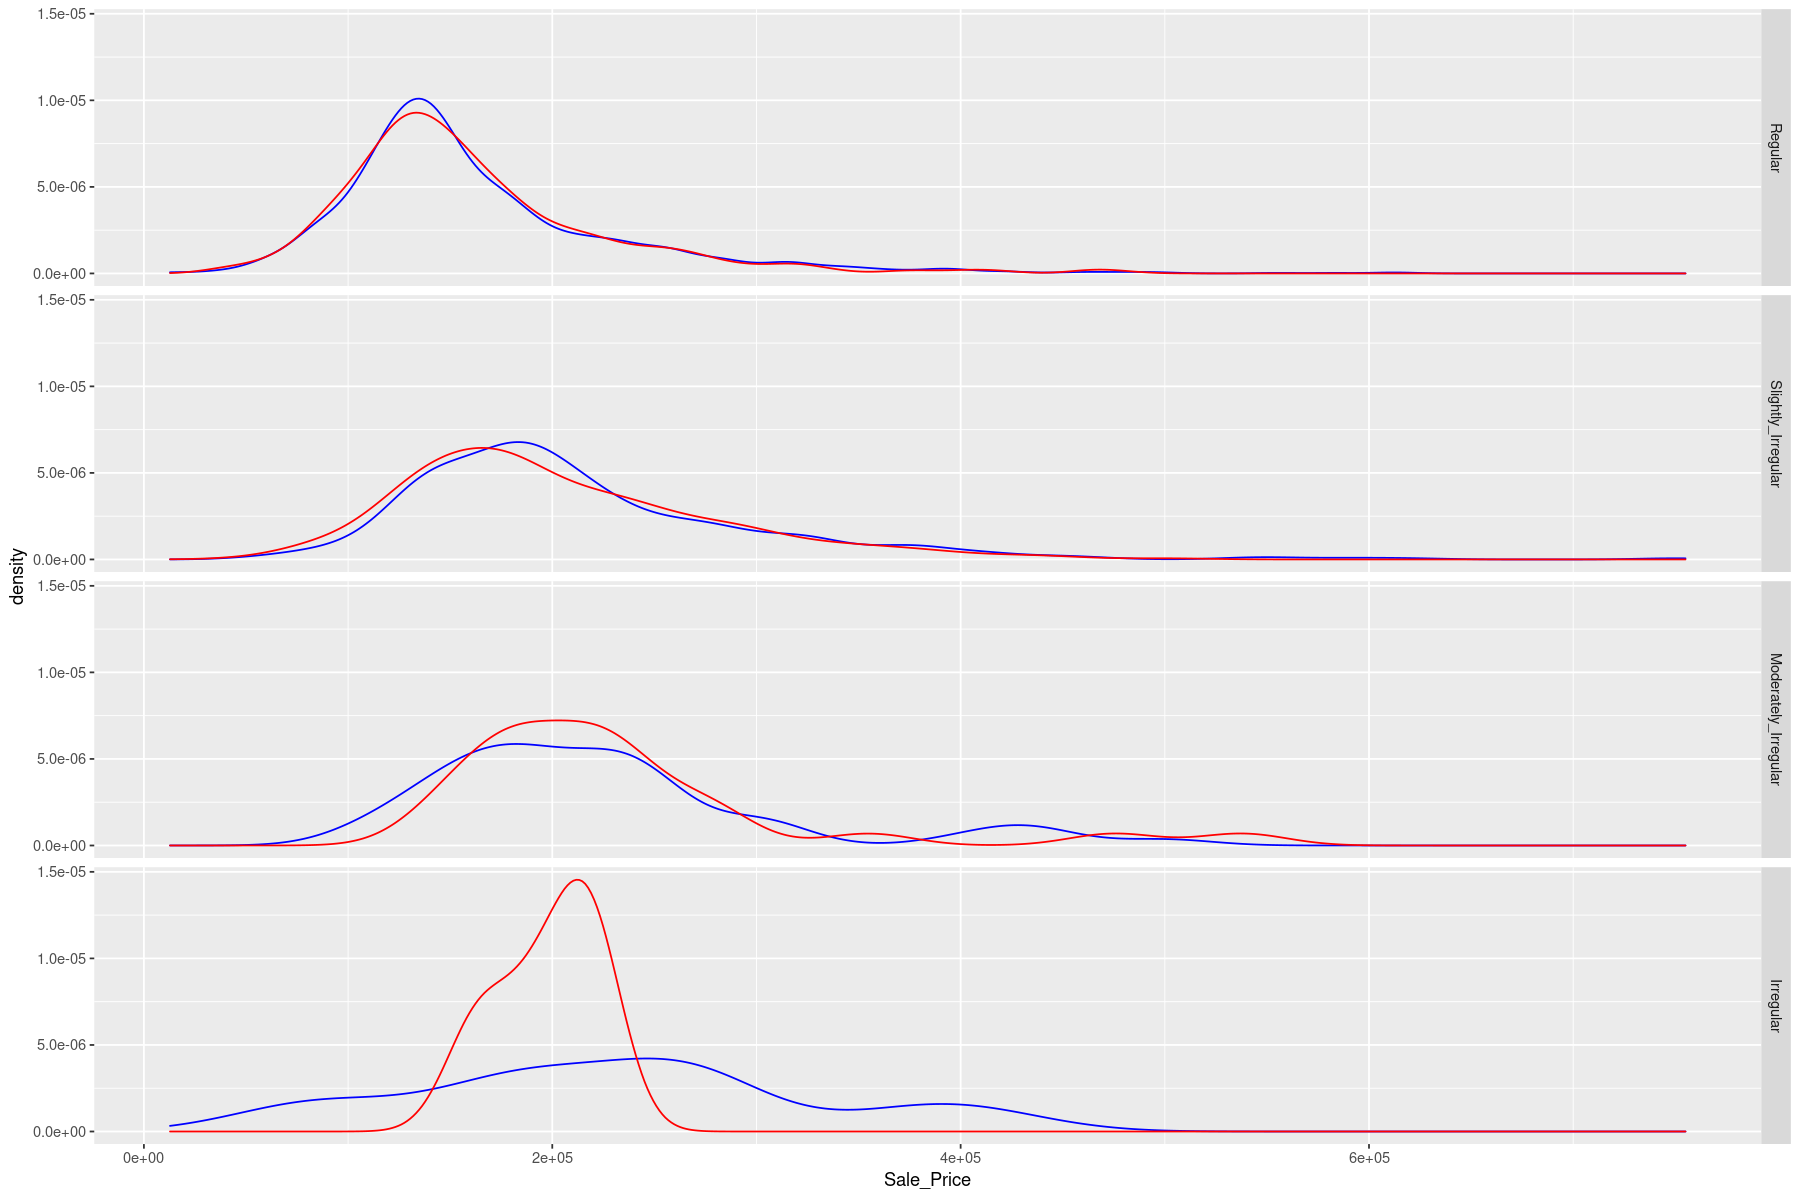

In [7]:
ggplot() + 
    geom_density(data=train_caret, aes(Sale_Price), color='blue') + 
    geom_density(data=test_caret, aes(Sale_Price), color='red') + 
    facet_grid(rows = vars(Lot_Shape))

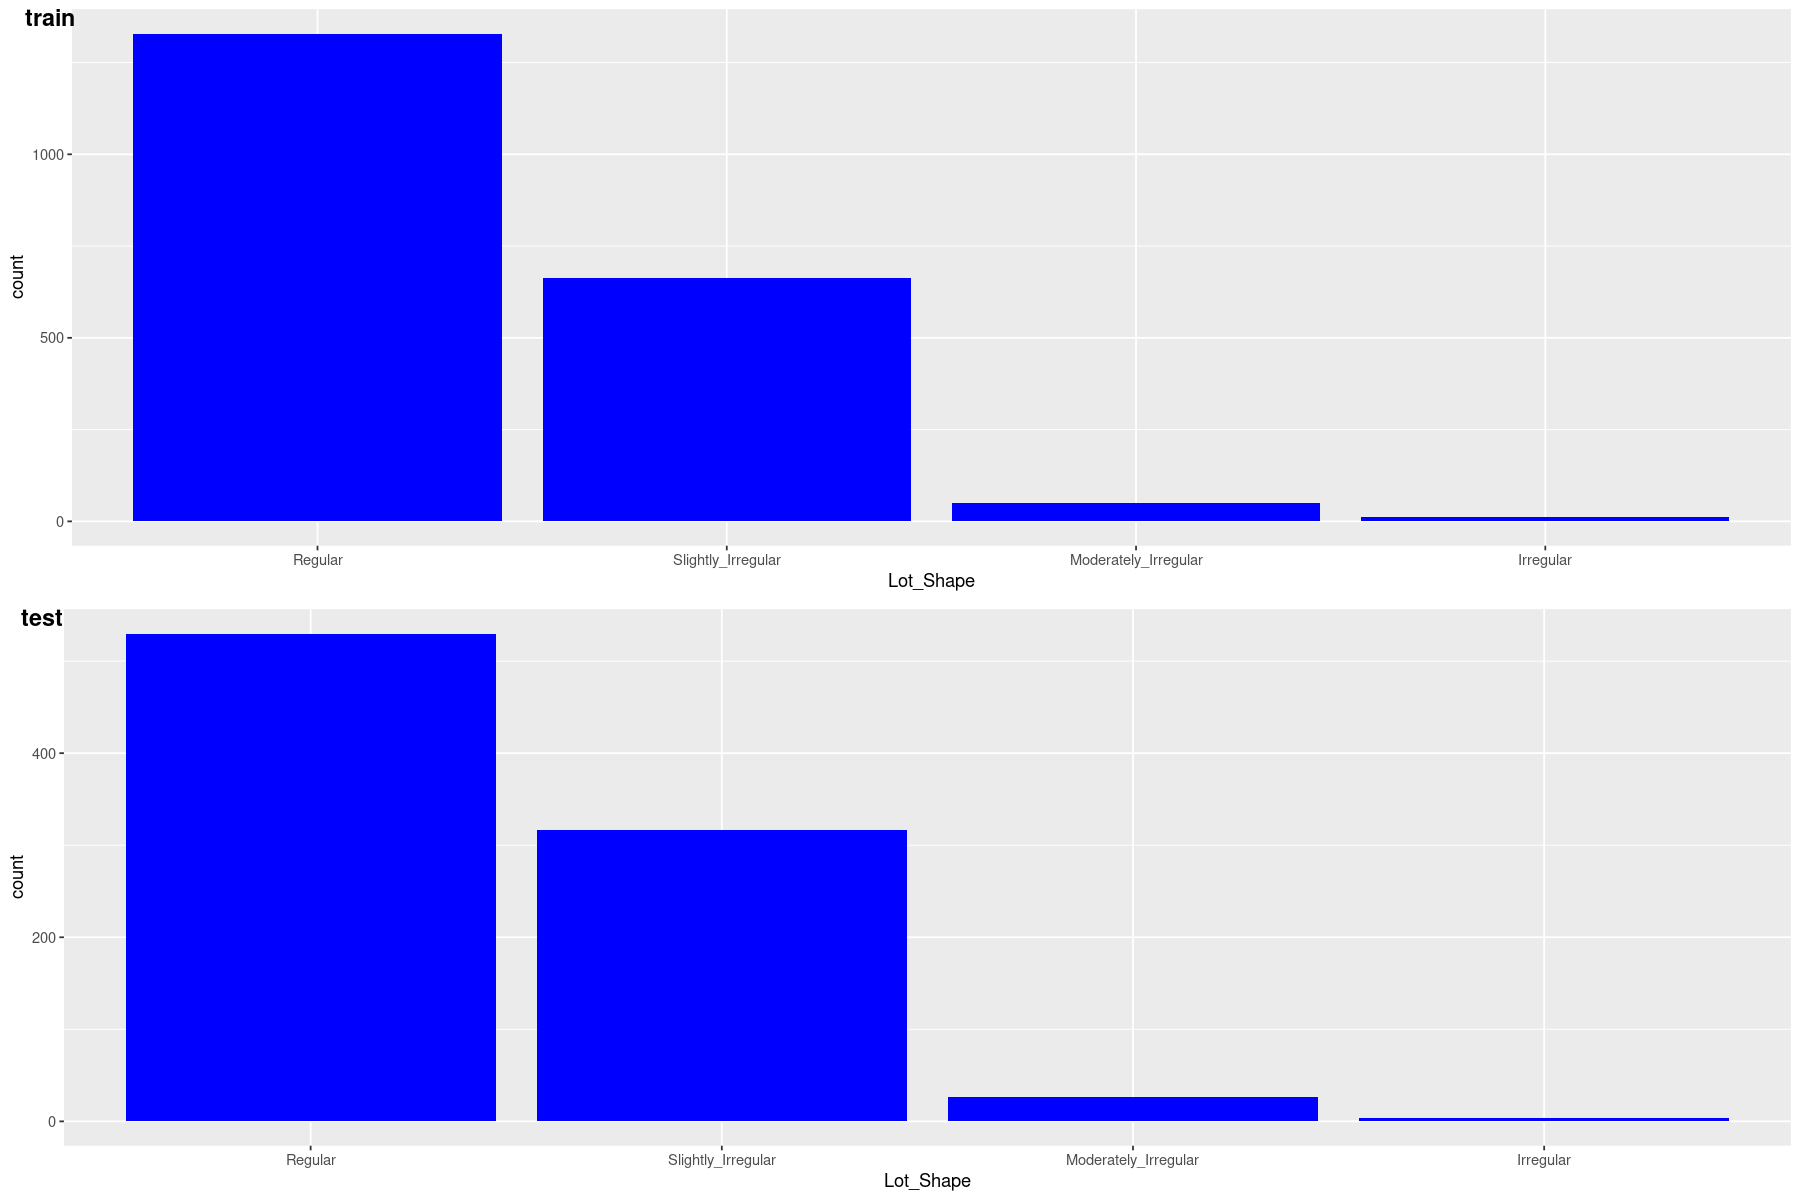

In [8]:
fig1 = ggplot() + 
    geom_bar(data=train_caret, aes(x=Lot_Shape), fill='blue')
fig2 = ggplot() + 
    geom_bar(data=test_caret, aes(x=Lot_Shape), fill='blue')
ggarrange(fig1, fig2, labels = c("train", "test"), ncol = 1, nrow = 2)

## Exploratory Data Analysis

In [9]:
# initial dimension
dim(ames)

[1] 2930   81

In [10]:
# response variable
head(ames$Sale_Price)

[1] 215000 105000 172000 244000 189900 195500

In [11]:
colnames(ames) 

[1] "MS_SubClass"        "MS_Zoning"          "Lot_Frontage"      
 [4] "Lot_Area"           "Street"             "Alley"             
 [7] "Lot_Shape"          "Land_Contour"       "Utilities"         
[10] "Lot_Config"         "Land_Slope"         "Neighborhood"      
[13] "Condition_1"        "Condition_2"        "Bldg_Type"         
[16] "House_Style"        "Overall_Qual"       "Overall_Cond"      
[19] "Year_Built"         "Year_Remod_Add"     "Roof_Style"        
[22] "Roof_Matl"          "Exterior_1st"       "Exterior_2nd"      
[25] "Mas_Vnr_Type"       "Mas_Vnr_Area"       "Exter_Qual"        
[28] "Exter_Cond"         "Foundation"         "Bsmt_Qual"         
[31] "Bsmt_Cond"          "Bsmt_Exposure"      "BsmtFin_Type_1"    
[34] "BsmtFin_SF_1"       "BsmtFin_Type_2"     "BsmtFin_SF_2"      
[37] "Bsmt_Unf_SF"        "Total_Bsmt_SF"      "Heating"           
[40] "Heating_QC"         "Central_Air"        "Electrical"        
[43] "First_Flr_SF"       "Second_Flr_SF"      "Low_Qual_Fin_SF"   
[46] "Gr_Liv_Area"        "Bsmt_Full_Bath"     "Bsmt_Half_Bath"    
[49] "Full_Bath"          "Half_Bath"          "Bedroom_AbvGr"     
[52] "Kitchen_AbvGr"      "Kitchen_Qual"       "TotRms_AbvGrd"     
[55] "Functional"         "Fireplaces"         "Fireplace_Qu"      
[58] "Garage_Type"        "Garage_Finish"      "Garage_Cars"       
[61] "Garage_Area"        "Garage_Qual"        "Garage_Cond"       
[64] "Paved_Drive"        "Wood_Deck_SF"       "Open_Porch_SF"     
[67] "Enclosed_Porch"     "Three_season_porch" "Screen_Porch"      
[70] "Pool_Area"          "Pool_QC"            "Fence"             
[73] "Misc_Feature"       "Misc_Val"           "Mo_Sold"           
[76] "Year_Sold"          "Sale_Type"          "Sale_Condition"    
[79] "Sale_Price"         "Longitude"          "Latitude"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



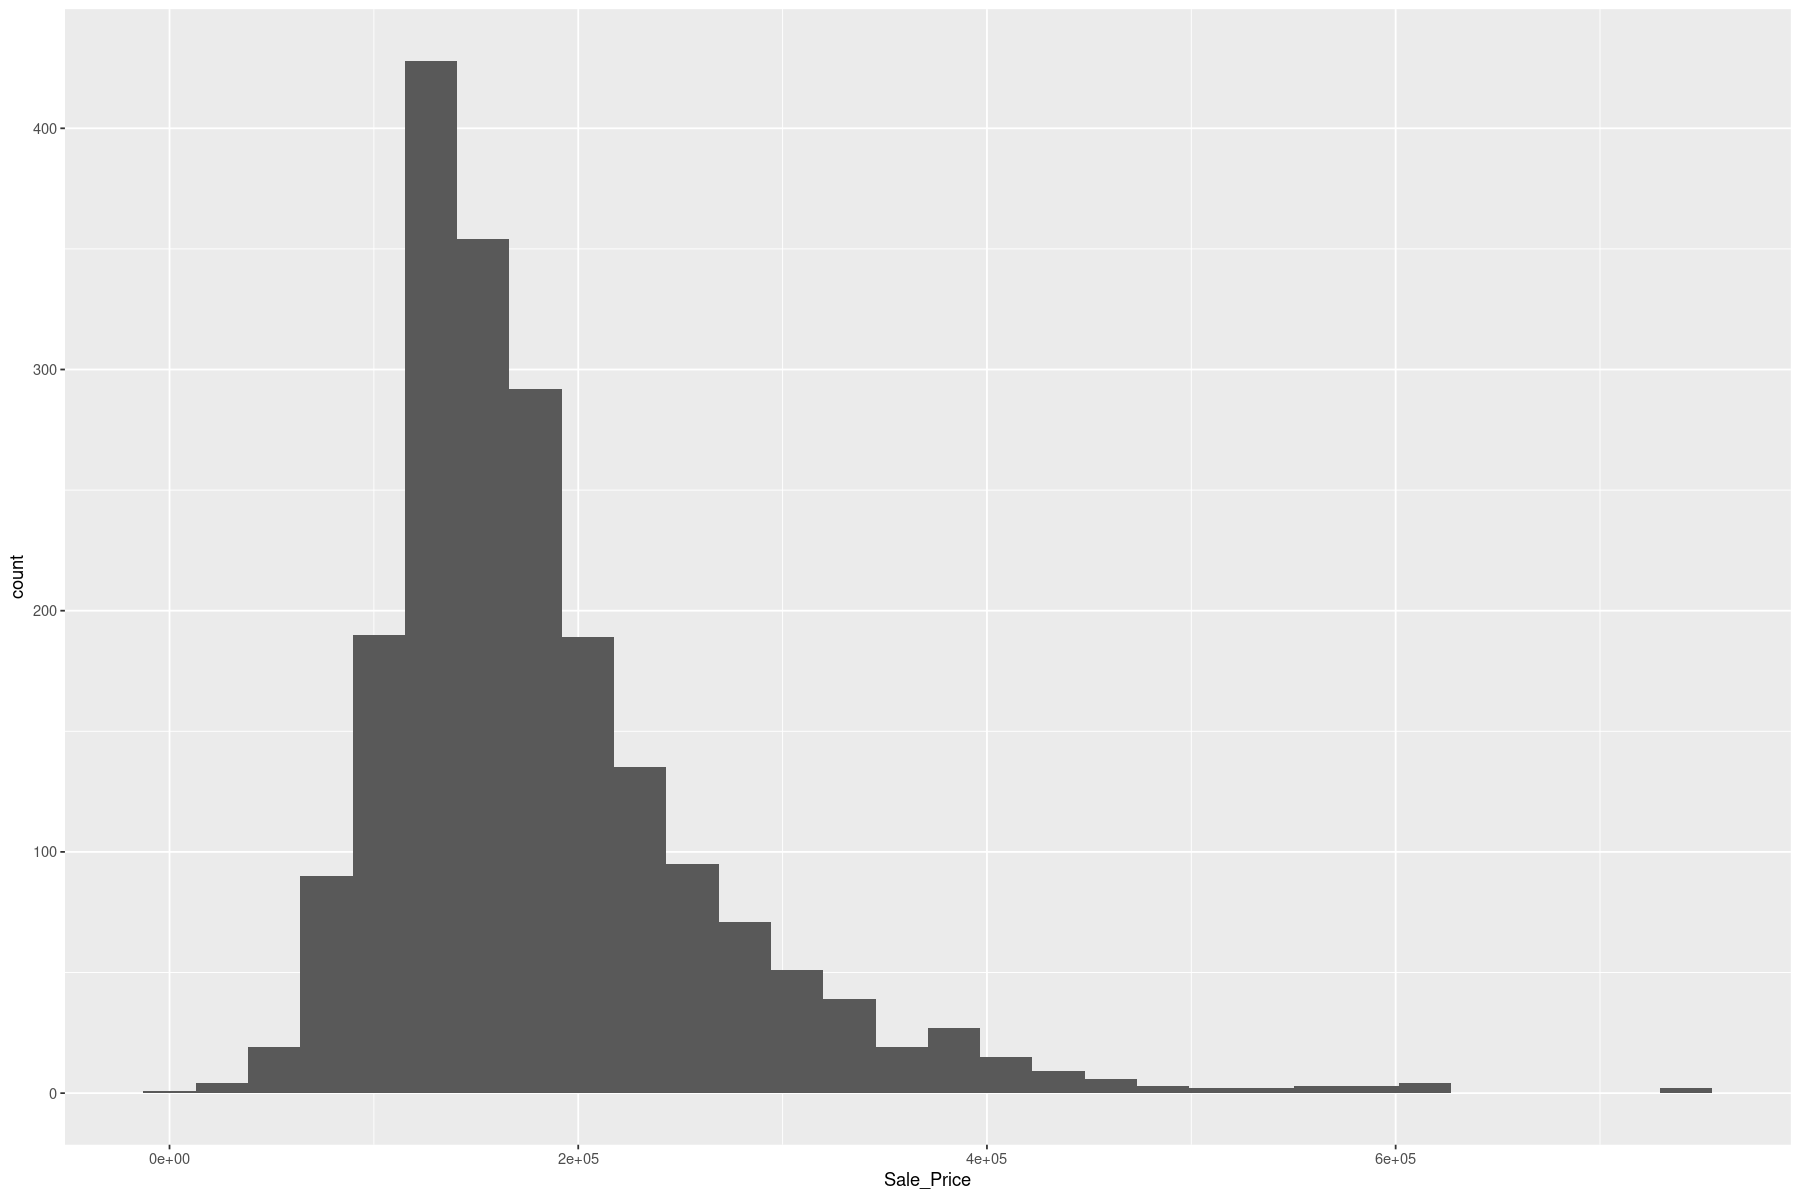

In [12]:
ggplot(data=train_caret, aes(x=Sale_Price), color='blue') + 
    geom_histogram()

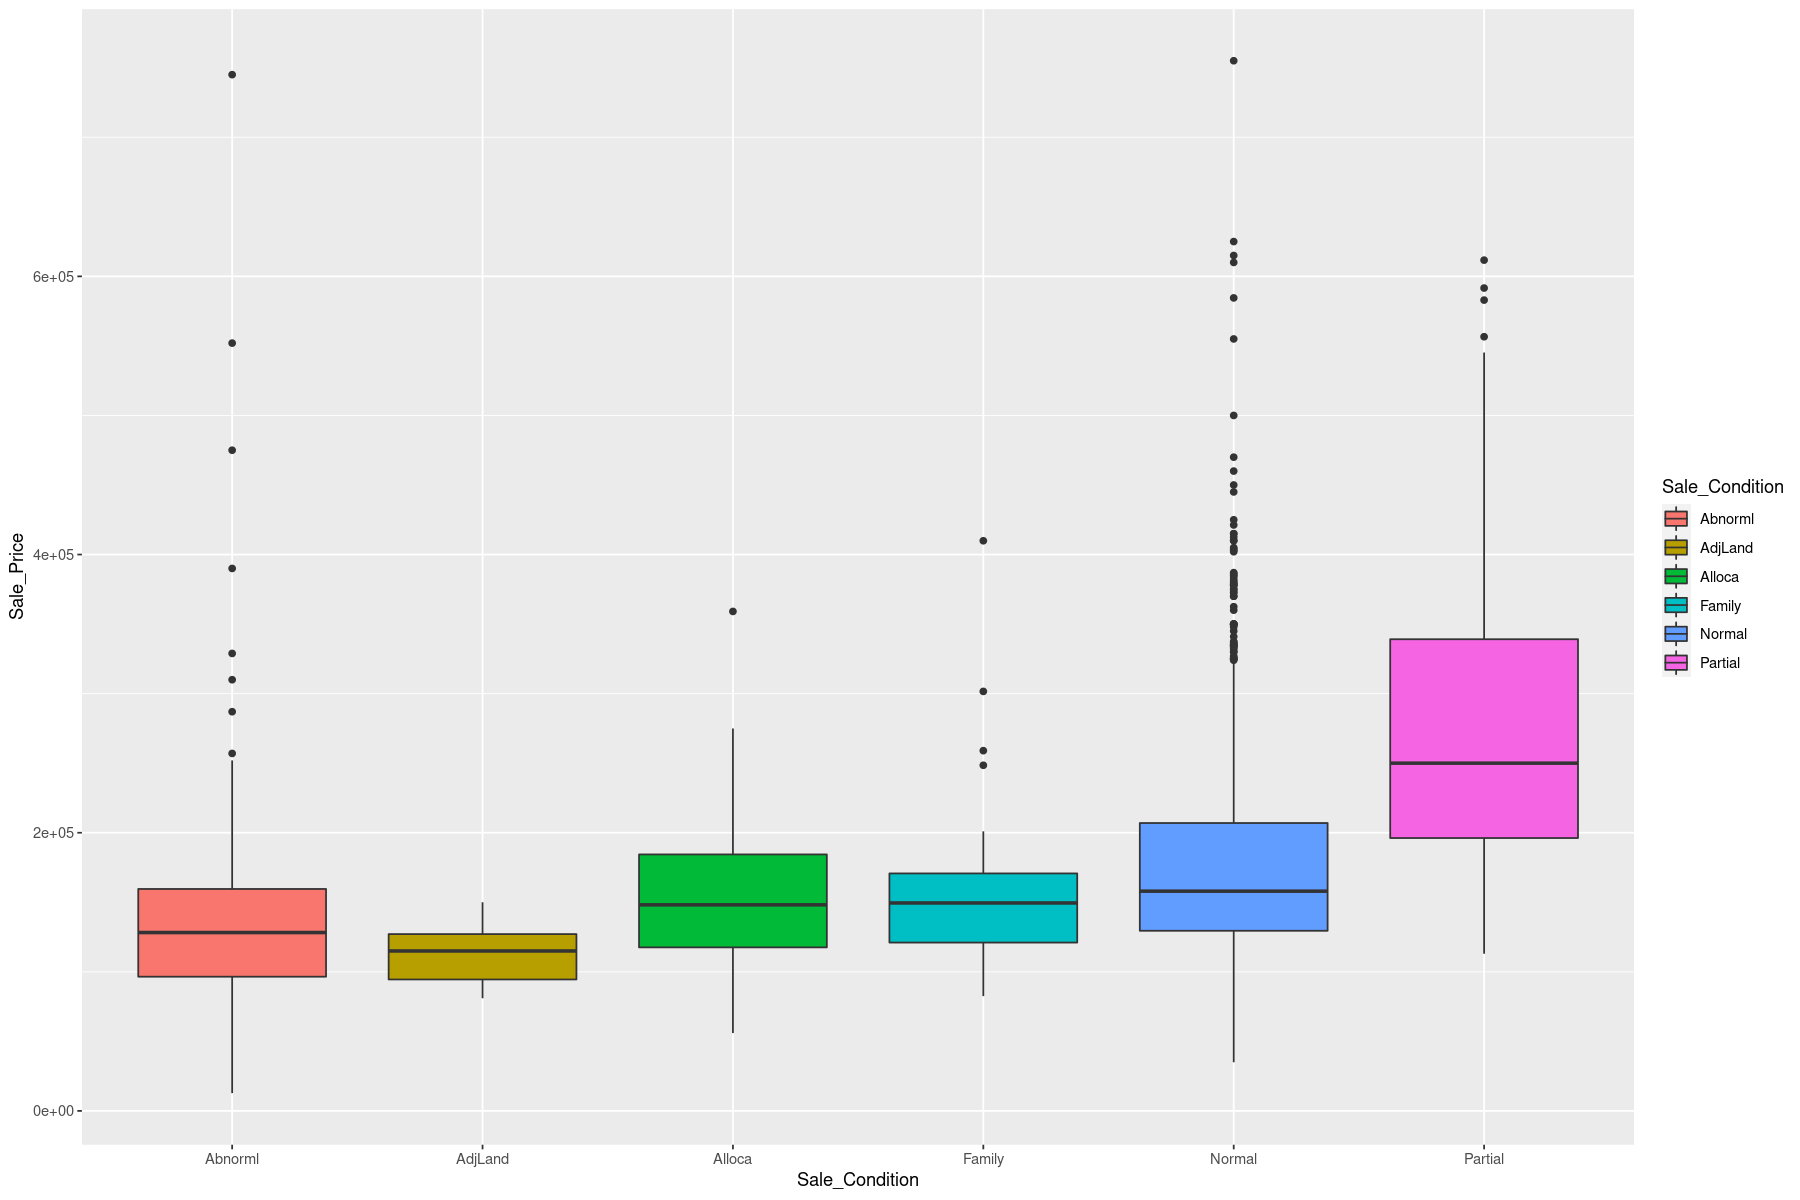

In [15]:
ggplot(data=train_caret, aes(x=Sale_Condition, y=Sale_Price, fill=Sale_Condition)) + 
    geom_boxplot()

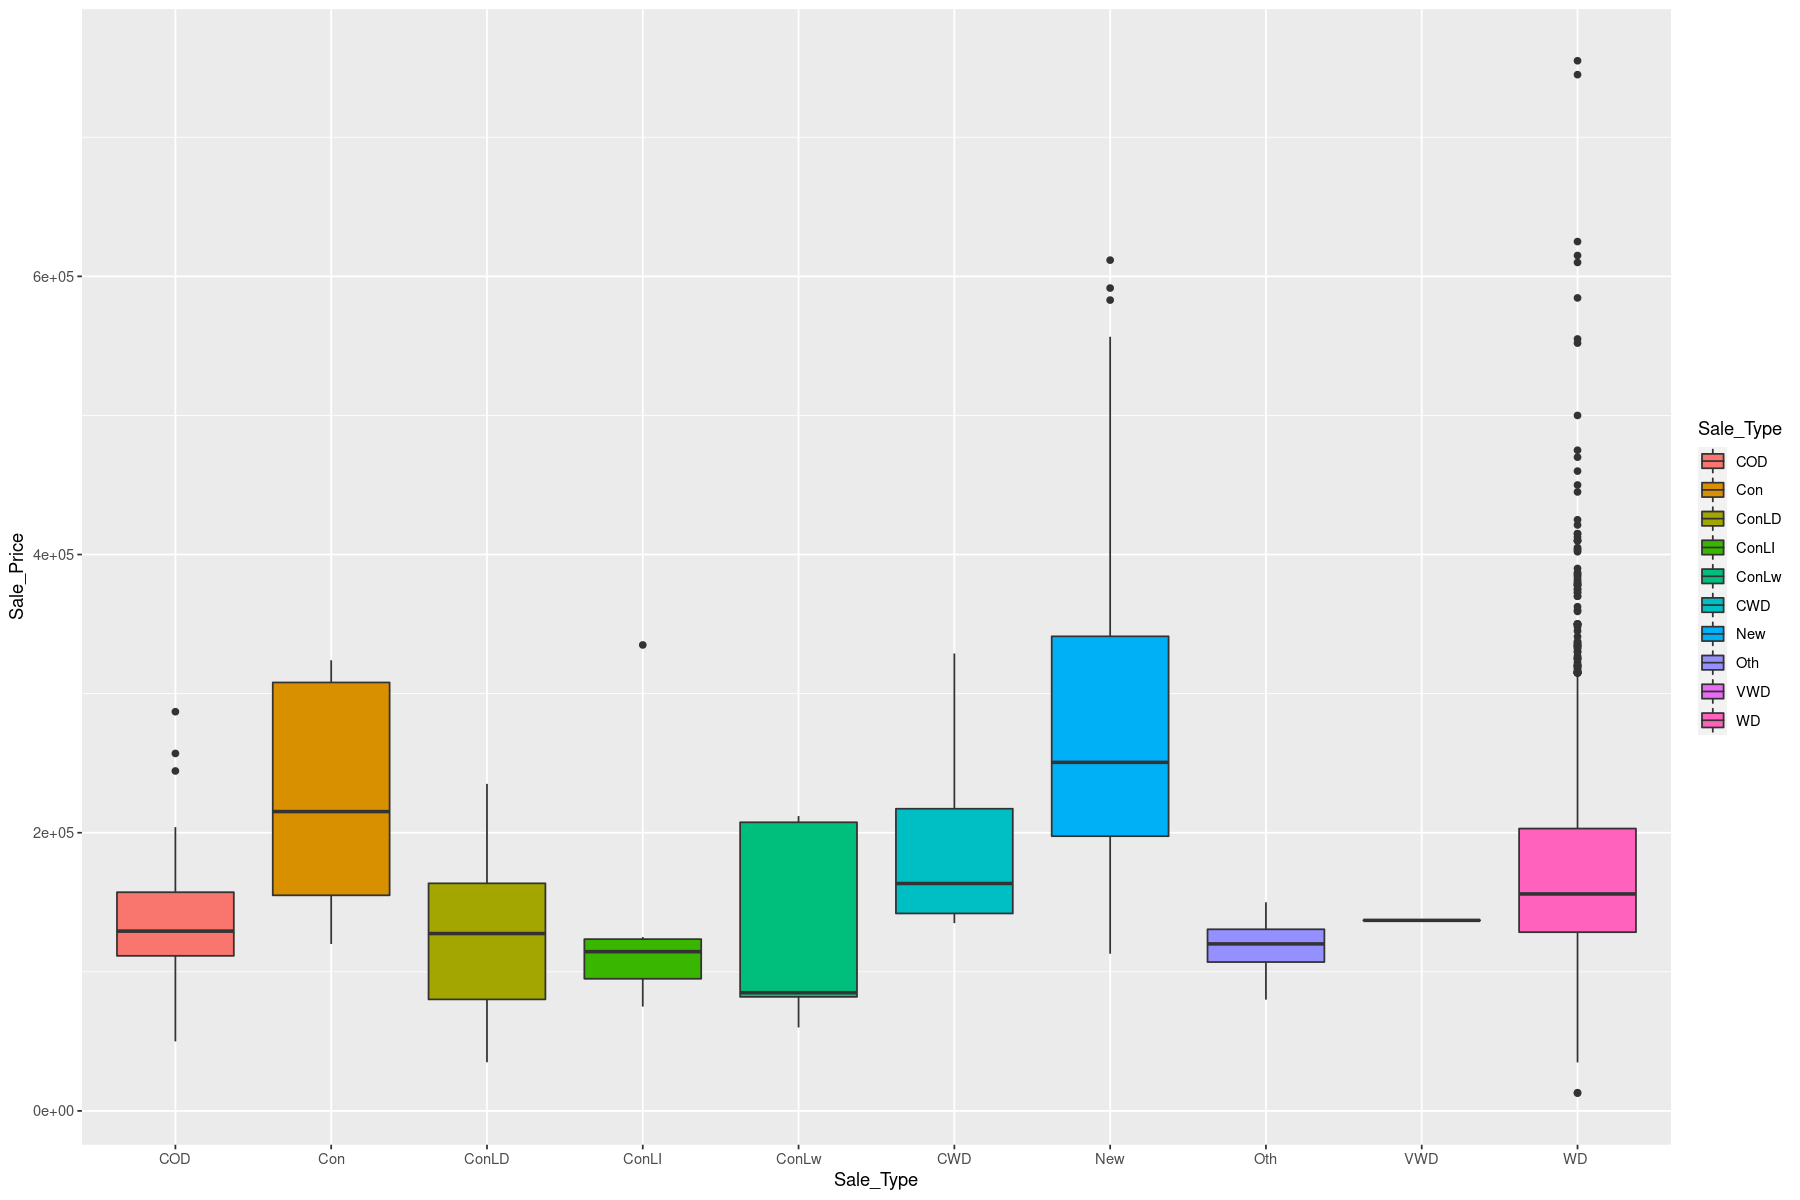

In [16]:
ggplot(data=train_caret, aes(x=Sale_Type, y=Sale_Price, fill=Sale_Type)) + 
    geom_boxplot()

Warning message:
“Removed 9 rows containing missing values (geom_point).”


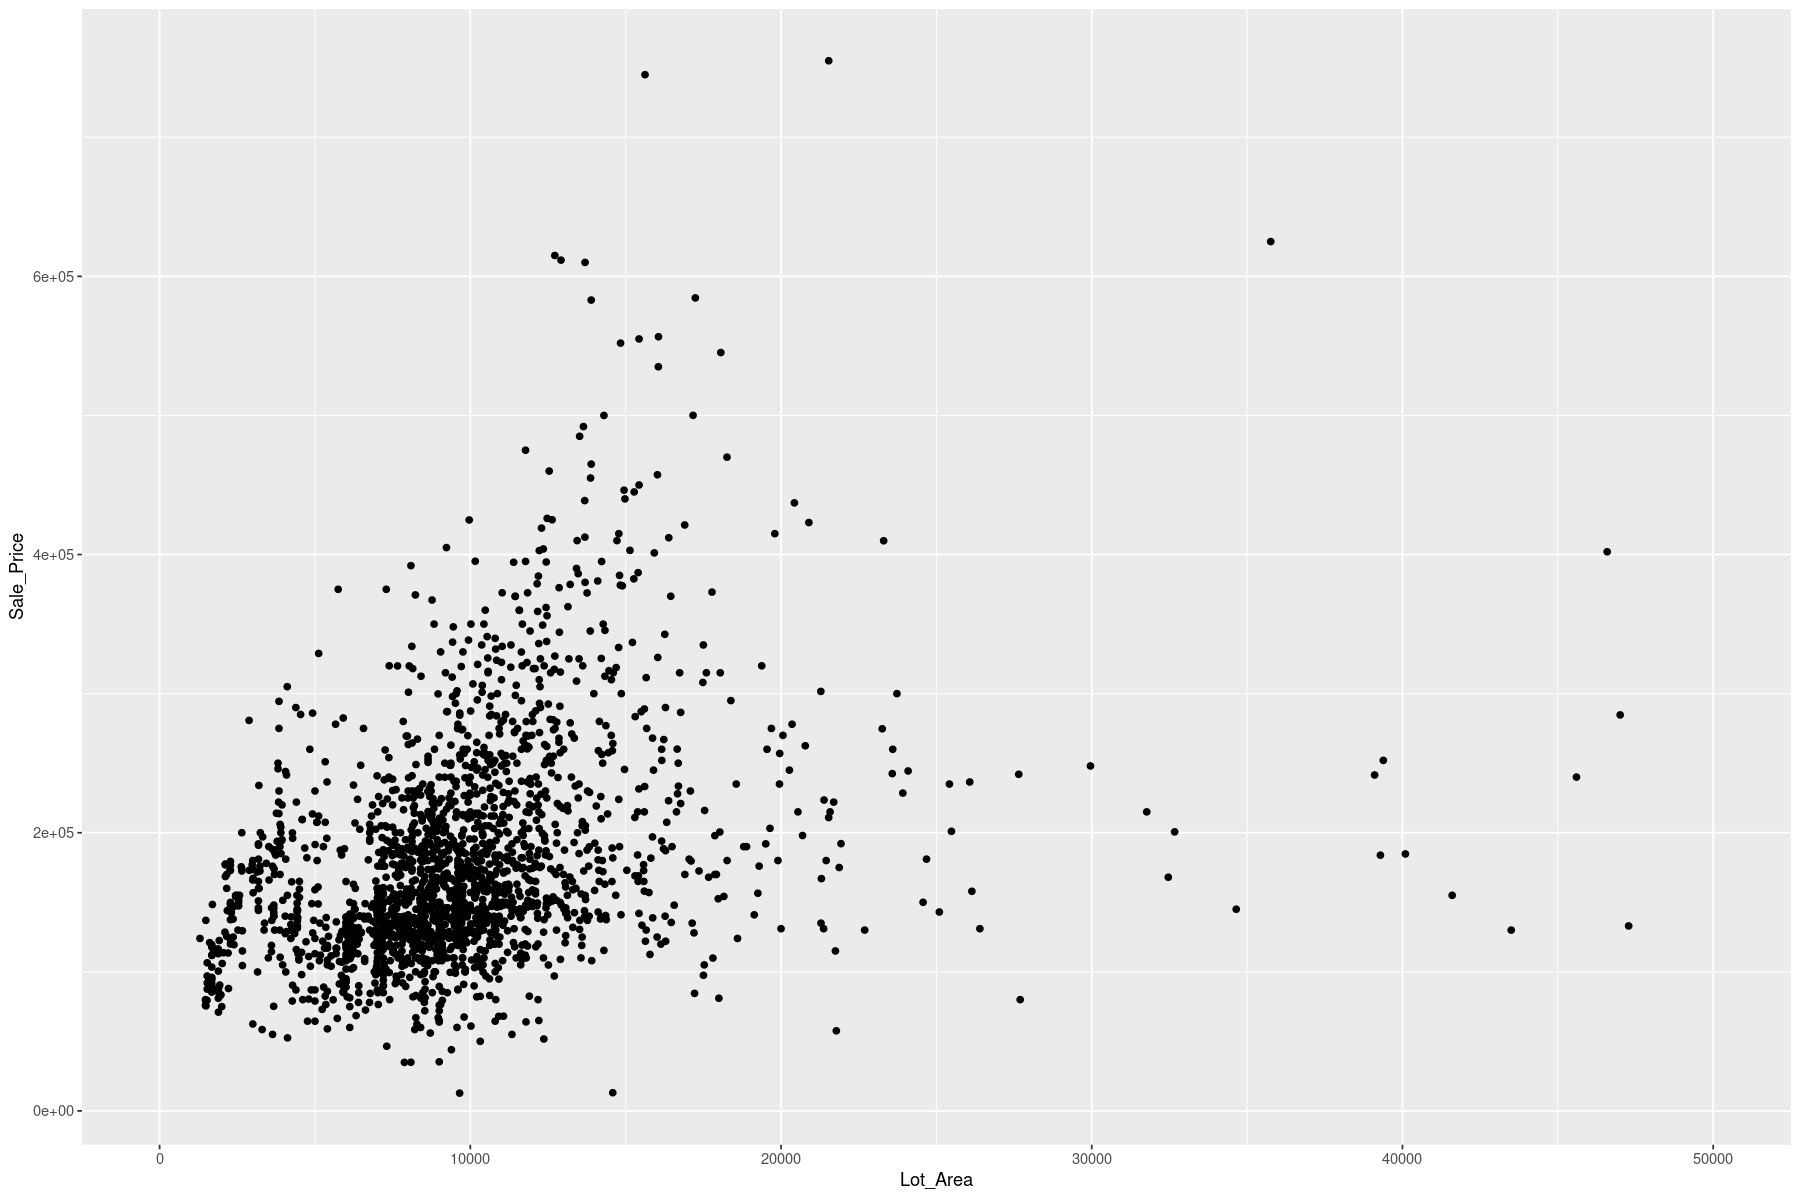

In [17]:
ggplot(data=train_caret, aes(x=Lot_Area, y=Sale_Price)) + 
    geom_point() + 
    xlim(0, 5e4)

## Modeling
R tiene un amplio abanico de librerías que implementan diferentes tipos de modelos e incluso varias implementaciones del mismo modelo pero con diferentes enfoques. Además de estos hay librerías que unifican estas para agilizar el proceso de modelo y estandarizar los procesos.

Hay diferentes formas de cómo se deben pasar la data para entrenar un modelo:
* Clásica de R usando una formula como una expresión simbólica de la relación de dependencia
    * `fn(Y ~ X)`
* usando separadamente $Y$, $X$ como argumentos independientes
    * `fn(x = ames[, features], y = ames$Sale_Price)`
* usando separadamente $Y$, $X$ pero pasando solo el nombre de las variables de un dataframe
    * `fn(x = c("Year_Sold", "Longitude", "Latitude"), y = "Sale_Price", data = ames.h2o)`

### Engines
Como se mencion anteriormente hay varias librerías que implementan por ejemplo el mismo modelo pero con diferente sabores, estos son conocidos como "engines"

[Classic linear models](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/lm)

In [18]:
lm_lm <- lm(Sale_Price ~ ., data = train_caret)
summary(lm_lm)


Call:
lm(formula = Sale_Price ~ ., data = train_caret)

Residuals:
    Min      1Q  Median      3Q     Max 
-246415   -9302       0    8812  150520 

Coefficients: (10 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                          -9.432e+06  1.178e+07
MS_SubClassOne_Story_1945_and_Older                   1.630e+03  3.751e+03
MS_SubClassOne_Story_with_Finished_Attic_All_Ages     1.186e+04  1.420e+04
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     1.244e+04  1.318e+04
MS_SubClassOne_and_Half_Story_Finished_All_Ages       5.322e+03  6.694e+03
MS_SubClassTwo_Story_1946_and_Newer                   9.435e+02  5.782e+03
MS_SubClassTwo_Story_1945_and_Older                   1.055e+04  6.338e+03
MS_SubClassTwo_and_Half_Story_All_Ages               -4.313e+03  1.085e+04
MS_SubClassSplit_or_Multilevel                       -9.660e+03  1.127e+04
MS_SubClassSplit_Foyer                     

[Generalized Linear Models](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm)

In [19]:
lm_glm <- glm(Sale_Price ~ ., data = train_caret, family = gaussian)
summary(lm_glm)


Call:
glm(formula = Sale_Price ~ ., family = gaussian, data = train_caret)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-246415    -9302        0     8812   150520  

Coefficients: (10 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                          -9.432e+06  1.178e+07
MS_SubClassOne_Story_1945_and_Older                   1.630e+03  3.751e+03
MS_SubClassOne_Story_with_Finished_Attic_All_Ages     1.186e+04  1.420e+04
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     1.244e+04  1.318e+04
MS_SubClassOne_and_Half_Story_Finished_All_Ages       5.322e+03  6.694e+03
MS_SubClassTwo_Story_1946_and_Newer                   9.435e+02  5.782e+03
MS_SubClassTwo_Story_1945_and_Older                   1.055e+04  6.338e+03
MS_SubClassTwo_and_Half_Story_All_Ages               -4.313e+03  1.085e+04
MS_SubClassSplit_or_Multilevel                       -9.660e+03  1.127e+04
MS_

 [Caret -> meta engine (aggregator)](http://topepo.github.io/caret/train-models-by-tag.html#linear-regression)

In [20]:
lm_caret <- train(Sale_Price ~ ., data = train_caret, method = "lm")
summary(lm_caret)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFi


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-246415   -9302       0    8812  150520 

Coefficients: (15 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                          -9.432e+06  1.178e+07
MS_SubClassOne_Story_1945_and_Older                   1.630e+03  3.751e+03
MS_SubClassOne_Story_with_Finished_Attic_All_Ages     1.186e+04  1.420e+04
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     1.244e+04  1.318e+04
MS_SubClassOne_and_Half_Story_Finished_All_Ages       5.322e+03  6.694e+03
MS_SubClassTwo_Story_1946_and_Newer                   9.435e+02  5.782e+03
MS_SubClassTwo_Story_1945_and_Older                   1.055e+04  6.338e+03
MS_SubClassTwo_and_Half_Story_All_Ages               -4.313e+03  1.085e+04
MS_SubClassSplit_or_Multilevel                       -9.660e+03  1.127e+04
MS_SubClassSplit_Foyer                               

In [21]:
lm_caret <- train(Sale_Price ~ ., data = train_caret, method = "glm")
summary(lm_caret)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misl


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-246415    -9302        0     8812   150520  

Coefficients: (15 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                          -9.432e+06  1.178e+07
MS_SubClassOne_Story_1945_and_Older                   1.630e+03  3.751e+03
MS_SubClassOne_Story_with_Finished_Attic_All_Ages     1.186e+04  1.420e+04
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     1.244e+04  1.318e+04
MS_SubClassOne_and_Half_Story_Finished_All_Ages       5.322e+03  6.694e+03
MS_SubClassTwo_Story_1946_and_Newer                   9.435e+02  5.782e+03
MS_SubClassTwo_Story_1945_and_Older                   1.055e+04  6.338e+03
MS_SubClassTwo_and_Half_Story_All_Ages               -4.313e+03  1.085e+04
MS_SubClassSplit_or_Multilevel                       -9.660e+03  1.127e+04
MS_SubClassSplit_Foyer                               -1.190e+03  7.

In [22]:
# Example using h2o
feature_names = colnames(train_h2o)

h2o.cv <- h2o.glm(
  x = feature_names[feature_names != "Sale_Price"], 
  y = "Sale_Price", 
  training_frame = train_h2o,
  #nfolds = 10  # perform 10-fold CV
)

### Linear regression
<img src="https://content.gnoss.ws/imagenes/Usuarios/ImagenesCKEditor/c513da9b-6419-42be-82ef-3c448a0b5a79/36c7bc05-5bc1-4266-9e1e-ee5f6ba6c312.png">
#### Univariable

In [23]:
ols_model <- lm(Sale_Price ~ Gr_Liv_Area, data = train_caret)
ols_model


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area, data = train_caret)

Coefficients:
(Intercept)  Gr_Liv_Area  
      12922          112  


In [24]:
summary(ols_model)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area, data = train_caret)

Residuals:
    Min      1Q  Median      3Q     Max 
-484837  -30577   -2954   22650  333962 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12922.409   4029.089   3.207  0.00136 ** 
Gr_Liv_Area   112.002      2.529  44.283  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 58800 on 2051 degrees of freedom
Multiple R-squared:  0.4888,	Adjusted R-squared:  0.4885 
F-statistic:  1961 on 1 and 2051 DF,  p-value: < 2.2e-16


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 23 rows containing non-finite values (stat_bin).”


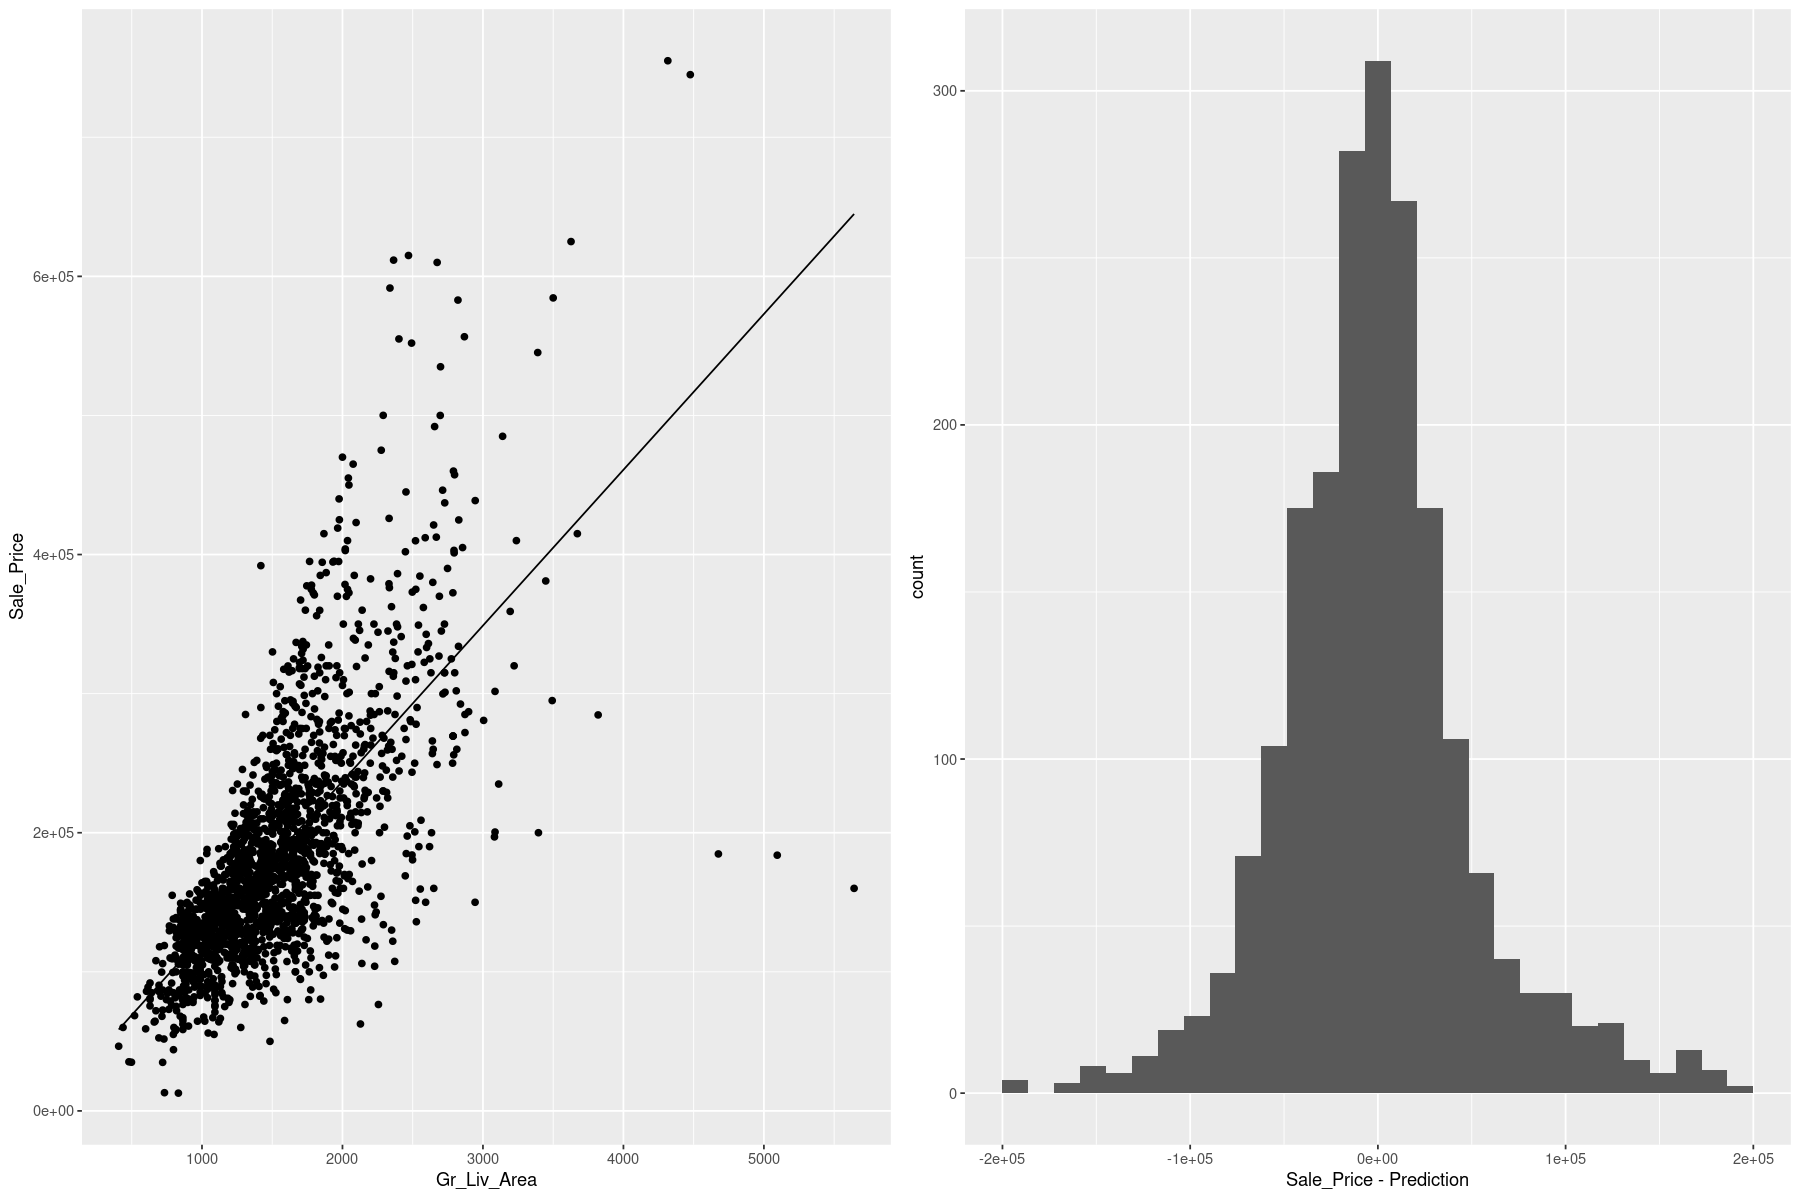

In [25]:
ols_pred = predict(ols_model, train_caret)
ols_result = data.frame(Gr_Liv_Area=train_caret$Gr_Liv_Area,
                        Sale_Price =train_caret$Sale_Price,
                        Prediction=ols_pred)

p1  <- ggplot(ols_result) + 
    geom_point(aes(x=Gr_Liv_Area, y=Sale_Price)) + 
    geom_line(aes(x=Gr_Liv_Area, y=Prediction))

p2  <- ggplot(ols_result, aes(x=Sale_Price - Prediction)) + 
    geom_histogram() + 
    xlim(-2e5, 2e5)

grid.arrange(p1, p2, nrow=1)

sigma es el MSE que es mostrado con la funcion summary arriba

In [ ]:
sigma(ols_model)

#### Bivariable

In [26]:
olsm_model <- lm(Sale_Price ~ Gr_Liv_Area + Year_Built, data = train_caret)
olsm_model


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = train_caret)

Coefficients:
(Intercept)  Gr_Liv_Area   Year_Built  
 -2.097e+06    9.611e+01    1.083e+03  


In [27]:
summary(olsm_model)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = train_caret)

Residuals:
    Min      1Q  Median      3Q     Max 
-459319  -28420   -2388   18197  306305 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.097e+06  7.094e+04  -29.56   <2e-16 ***
Gr_Liv_Area  9.611e+01  2.180e+00   44.09   <2e-16 ***
Year_Built   1.083e+03  3.636e+01   29.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 49140 on 2050 degrees of freedom
Multiple R-squared:  0.6431,	Adjusted R-squared:  0.6428 
F-statistic:  1847 on 2 and 2050 DF,  p-value: < 2.2e-16


In [28]:
olsm_pred = predict(olsm_model, train_caret)
olsm_result = data.frame(Gr_Liv_Area=train_caret$Gr_Liv_Area,
                        Sale_Price =train_caret$Sale_Price,
                        Prediction=olsm_pred)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 17 rows containing non-finite values (stat_bin).”


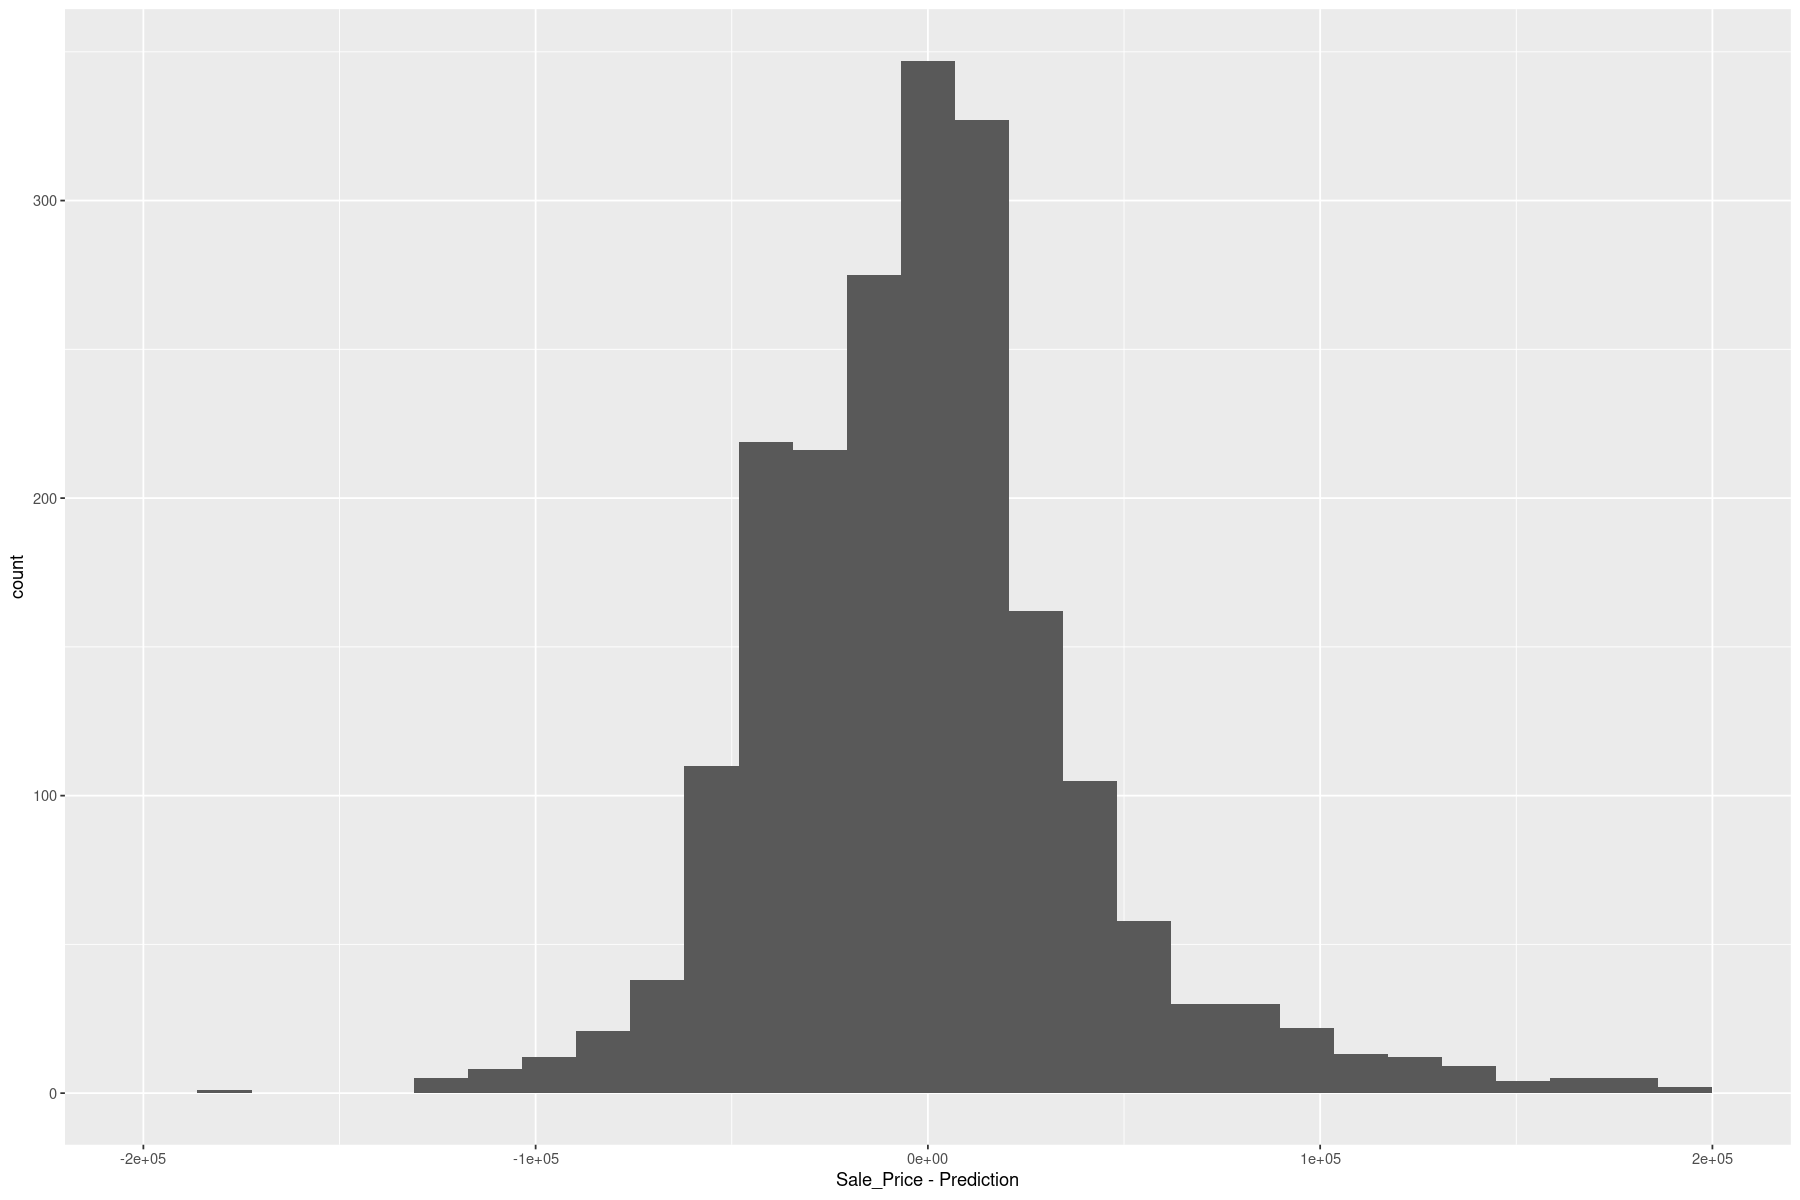

In [29]:
ggplot(olsm_result, aes(x=Sale_Price - Prediction)) + 
    geom_histogram() + 
    xlim(-2e5, 2e5)


#### Multivariable

In [ ]:
olsfull_model <- lm(Sale_Price ~ ., data = train_caret)
olsfull_model

In [ ]:
summary(olsfull_model)

In [ ]:
olsfull_pred = predict(olsfull_model, train_caret)
olsfull_result = data.frame(Sale_Price =train_caret$Sale_Price,
                            Prediction=olsfull_pred)


In [ ]:
p1 <- ggplot(olsfull_result, aes(x=Sale_Price, y=Prediction)) + 
    geom_point()

p2 <- ggplot(olsfull_result, aes(x=Sale_Price - Prediction)) + 
    geom_histogram() + 
    xlim(-2e5, 2e5)

ggarrange(p1, p2, ncol = 2)

#### Assessing model accuracy
 which model is “best”? To answer this question we have to define what we mean by “best”. In our case, we’ll use the RMSE metric and cross-validation (Section 2.4) to determine the “best” model. We can use the caret::train() function to train a linear model (i.e., method = "lm") using cross-validation (or a variety of other validation methods). In practice, a number of factors should be considered in determining a “best” model (e.g., time constraints, model production cost, predictive accuracy, etc.). The benefit of caret is that it provides built-in cross-validation capabilities, whereas the lm() function does not19. The following code chunk uses caret::train() to refit model1 using 10-fold cross-validation:

In [30]:
set.seed(123)
cv_ols <- train(
    form = Sale_Price ~ .,
    #form = Sale_Price ~ Gr_Liv_Area + Year_Built,
    data = train_caret,
    method = 'lm'
    #trControl = trainControl(method = 'cv', number = 10, p=.95)
)
cv_ols

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFi

Linear Regression 

2053 samples
  80 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2053, 2053, 2053, 2053, 2053, 2053, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  51425.04  0.6844537  19837.79

Tuning parameter 'intercept' was held constant at a value of TRUE

In [31]:
summary(cv_ols)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-246415   -9302       0    8812  150520 

Coefficients: (15 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                          -9.432e+06  1.178e+07
MS_SubClassOne_Story_1945_and_Older                   1.630e+03  3.751e+03
MS_SubClassOne_Story_with_Finished_Attic_All_Ages     1.186e+04  1.420e+04
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     1.244e+04  1.318e+04
MS_SubClassOne_and_Half_Story_Finished_All_Ages       5.322e+03  6.694e+03
MS_SubClassTwo_Story_1946_and_Newer                   9.435e+02  5.782e+03
MS_SubClassTwo_Story_1945_and_Older                   1.055e+04  6.338e+03
MS_SubClassTwo_and_Half_Story_All_Ages               -4.313e+03  1.085e+04
MS_SubClassSplit_or_Multilevel                       -9.660e+03  1.127e+04
MS_SubClassSplit_Foyer                               

In [32]:
df1 <- broom::augment(cv_ols$finalModel, data = train_caret["Sale_Price"])
head(df1)

Sale_Price,.fitted,.std.resid,.hat,.sigma,.cooksd
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
215000,221995.3,-0.35160415,0.16584964,21788.90,8.360473e-05
105000,122589.5,-0.87012929,0.13883808,21784.98,4.151873e-04
172000,173311.9,-0.07650843,0.38038477,21789.63,1.222284e-05
244000,276501.1,-1.56779688,0.09434872,21774.44,8.709782e-04
189900,190401.5,-0.02350865,0.04104954,21789.66,8.046740e-08
195500,194168.7,0.06270485,0.05012672,21789.64,7.057625e-07


Warning message:
“Use of `df1$.fitted` is discouraged. Use `.fitted` instead.”
Warning message:
“Use of `df1$Sale_Price` is discouraged. Use `Sale_Price` instead.”
Warning message:
“Use of `df1$.fitted` is discouraged. Use `.fitted` instead.”


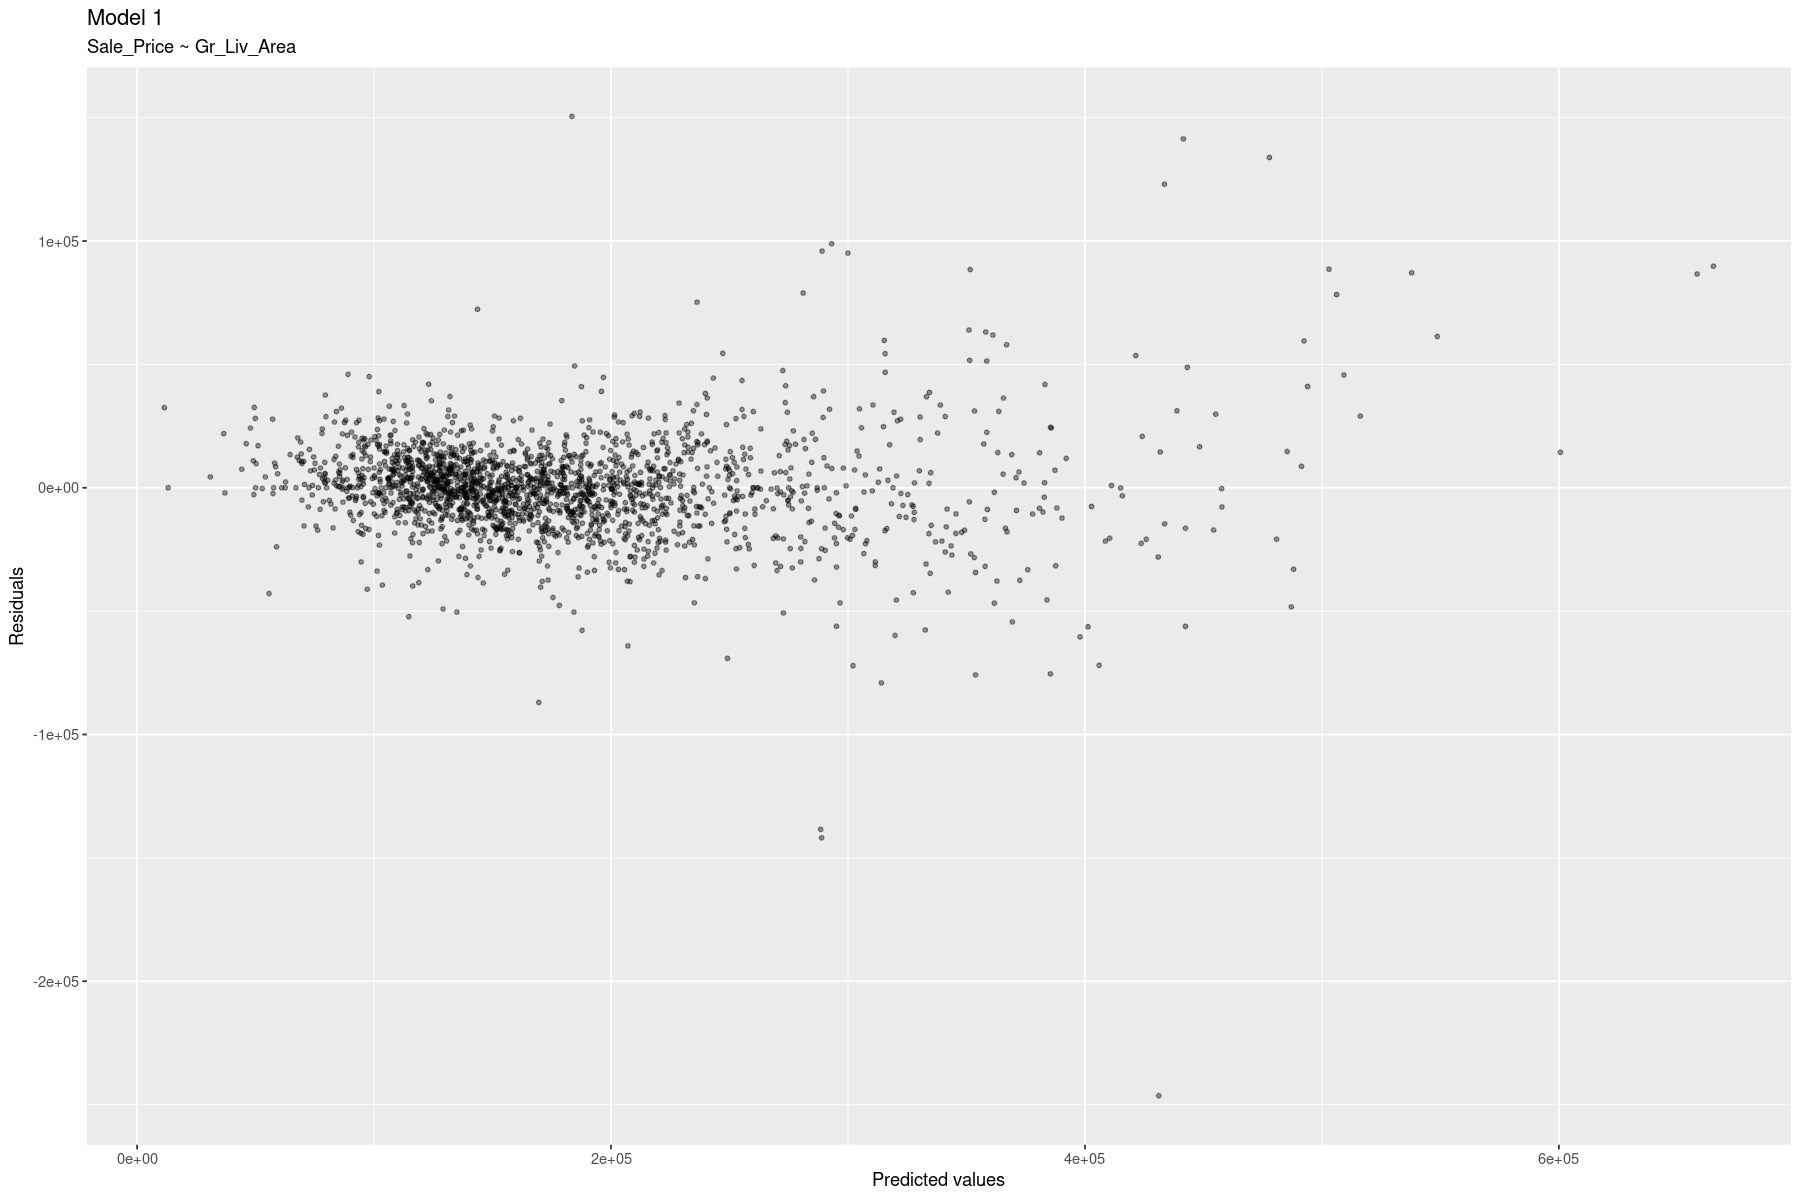

In [33]:
ggplot(df1, aes(x=df1$.fitted, y=(df1$Sale_Price - df1$.fitted))) + 
  geom_point(size = 1, alpha = .4) +
  xlab("Predicted values") +
  ylab("Residuals") +
  ggtitle("Model 1", subtitle = "Sale_Price ~ Gr_Liv_Area")


#### Feature interpretation
We can use vip::vip() to extract and plot the most important variables. The importance measure is normalized from 100 (most important) to 0 (least important).

In [ ]:
install.packages('pls')

In [34]:
set.seed(123)
cv_ols <- train(
    form = Sale_Price ~ .,
    #form = Sale_Price ~ Gr_Liv_Area + Year_Built,
    data = train_caret,
    method = 'lm',
    preProcess = c("zv", "center", "scale"),
    trControl = trainControl(method = 'cv', number = 10),
    tuneLength = 10
)
cv_ols

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFi

Linear Regression 

2053 samples
  80 predictor

Pre-processing: centered (303), scaled (303), remove (5) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1846, 1848, 1848, 1848, 1848, 1848, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  38824.71  0.7905183  18001.04

Tuning parameter 'intercept' was held constant at a value of TRUE

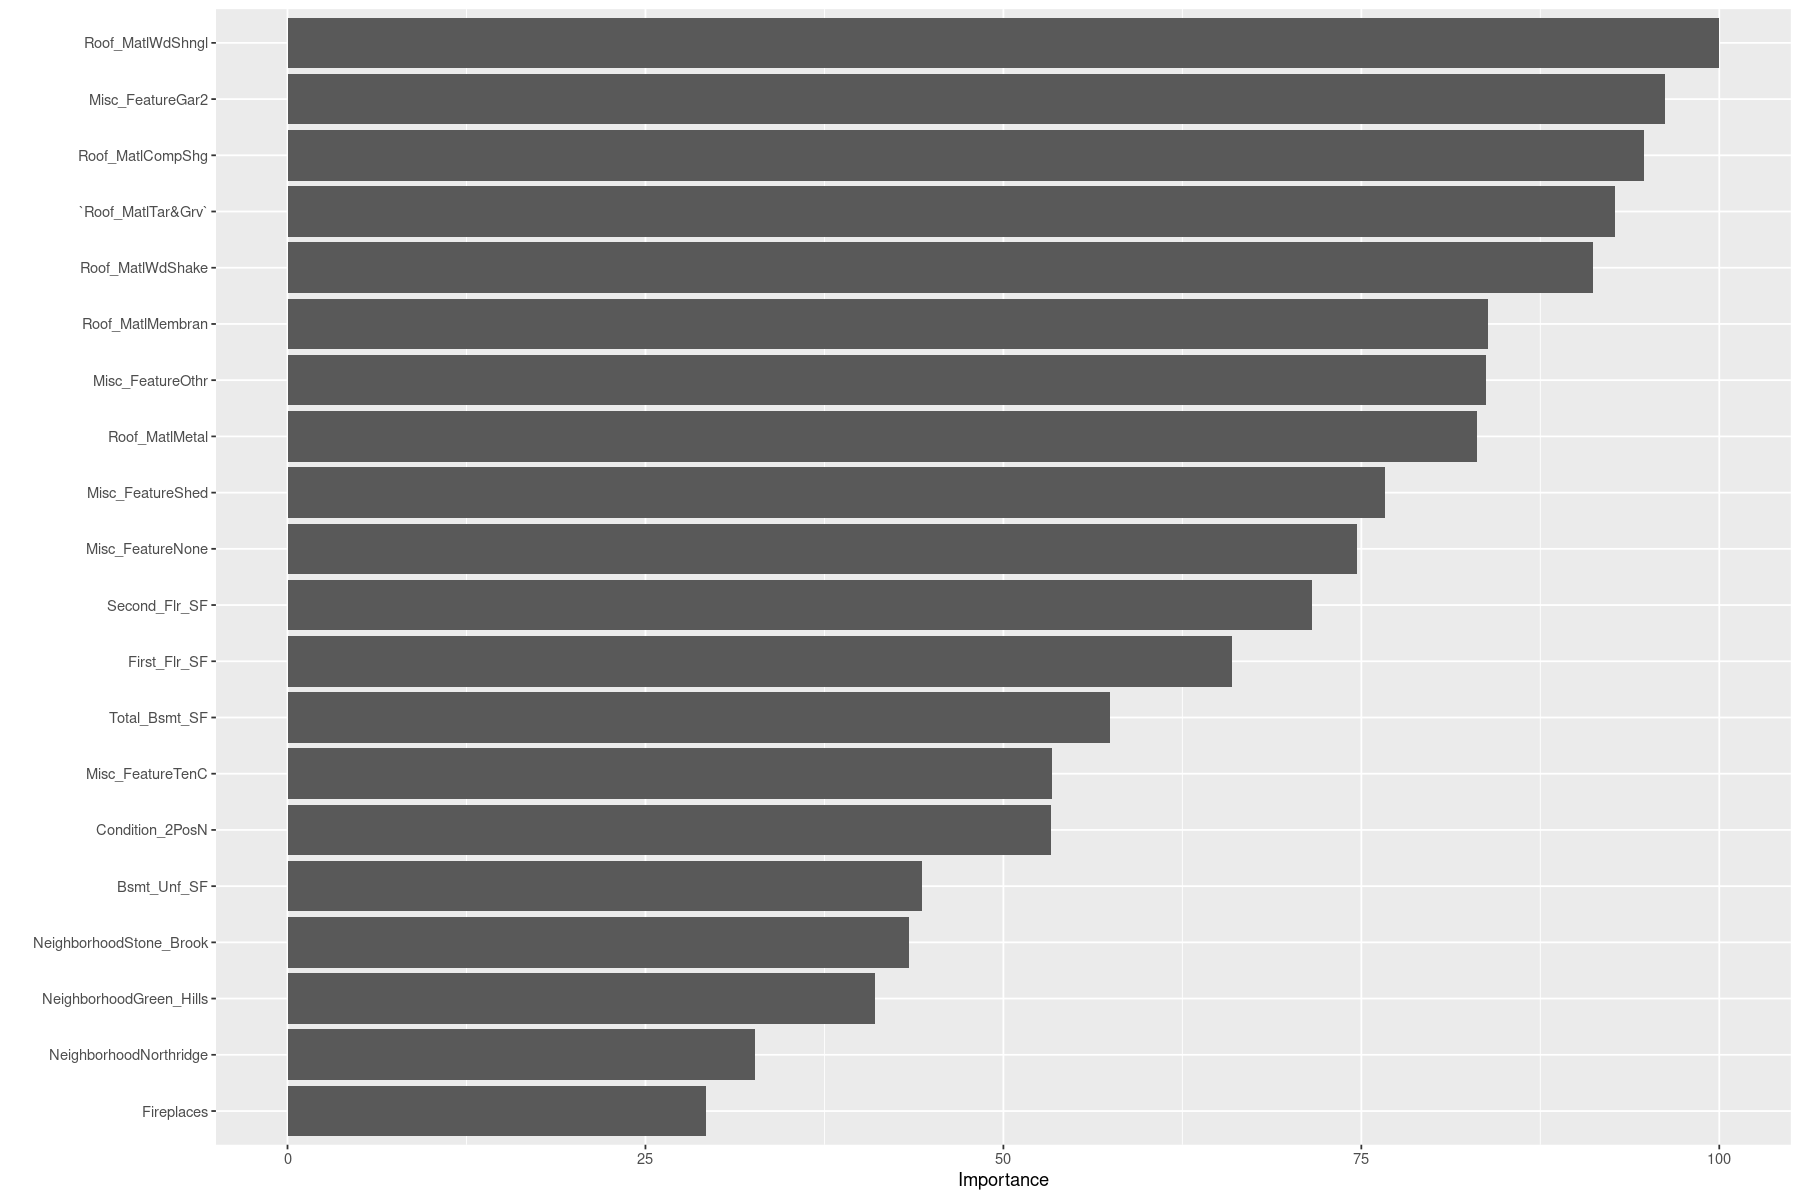

In [35]:
vip(cv_ols, num_features = 20, method = "model")

# Classification

## Load Data

In [36]:
data("attrition", package = "modeldata")


In [ ]:
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)
attrition_h2o <- as.h2o(attrition)

In [37]:
# initial dimension
dim(attrition)

[1] 1470   31

In [ ]:
# response variable
head(attrition)

## Data Spliting

In [39]:
# Using base R
set.seed(123)  # for reproducibility
index_1 <- sample(1:nrow(attrition), round(nrow(attrition) * 0.7))
train_base_ <- attrition[index_1, ]
test_base  <- attrition[-index_1, ]

# Using caret package

index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
train_caret <- attrition[index_caret, ]
test_caret  <- attrition[-index_caret, ]

# Using rsample package
split_1  <- initial_split(data = attrition, prop = 0.7, strata = "Attrition")
train_3  <- training(split_1)
test_3   <- testing(split_1)

# Using h2o package
#split_2 <- h2o.splitFrame(attrition_h2o, ratios = 0.7, seed = 123)
#train_4 <- split_2[[1]]
#test_4  <- split_2[[2]]

## EDA

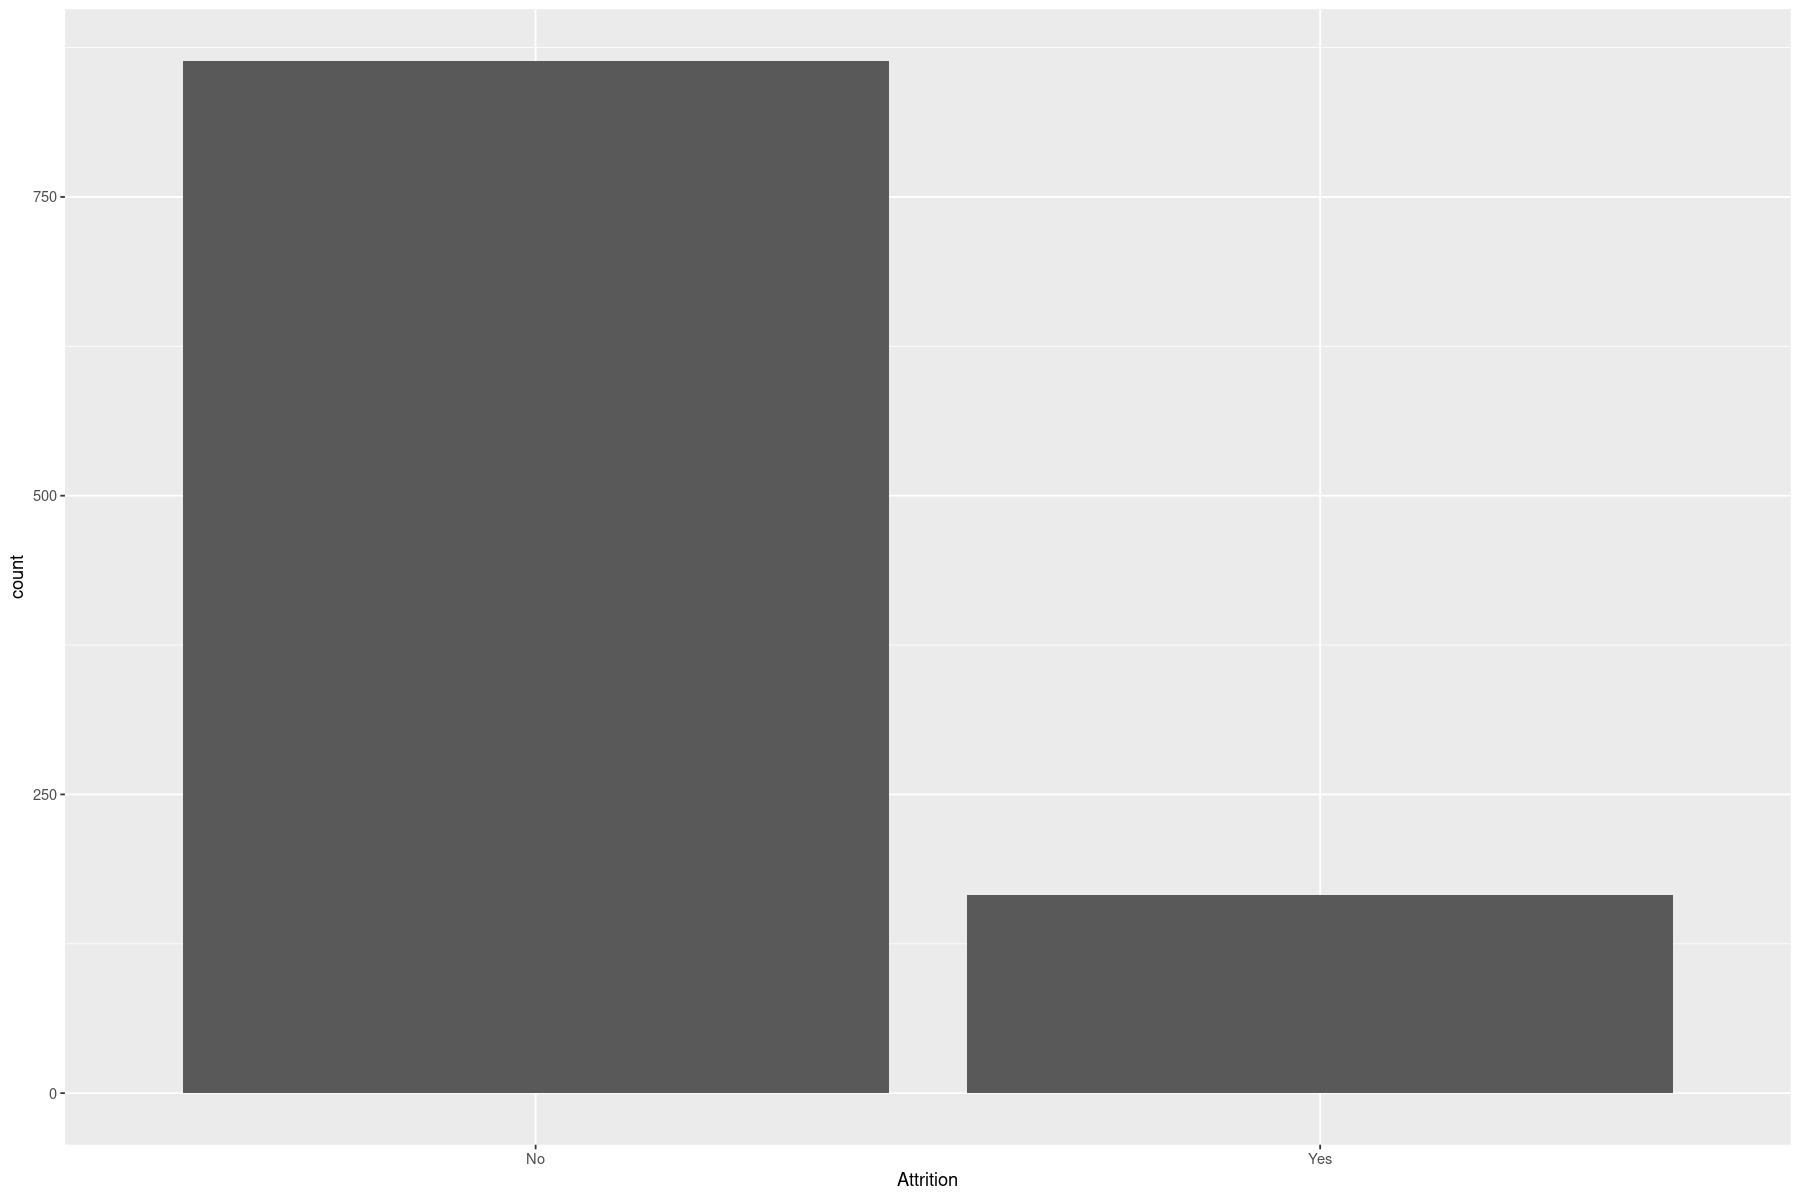

In [40]:
ggplot(train_caret, aes(x=Attrition)) + geom_bar()

In [41]:
train_caret %>% 
    count(Attrition) %>%
    mutate(perc = n / nrow(train_caret))

Attrition,n,perc
<fct>,<int>,<dbl>
No,864,0.838835
Yes,166,0.161165


In [42]:
test_caret %>% 
    count(Attrition) %>%
    mutate(perc = n / nrow(test_caret))

Attrition,n,perc
<fct>,<int>,<dbl>
No,369,0.8386364
Yes,71,0.1613636


In [43]:
tibble(colnames(train_caret))

colnames(train_caret)
<chr>
Age
Attrition
BusinessTravel
DailyRate
Department
DistanceFromHome
Education
EducationField
EnvironmentSatisfaction


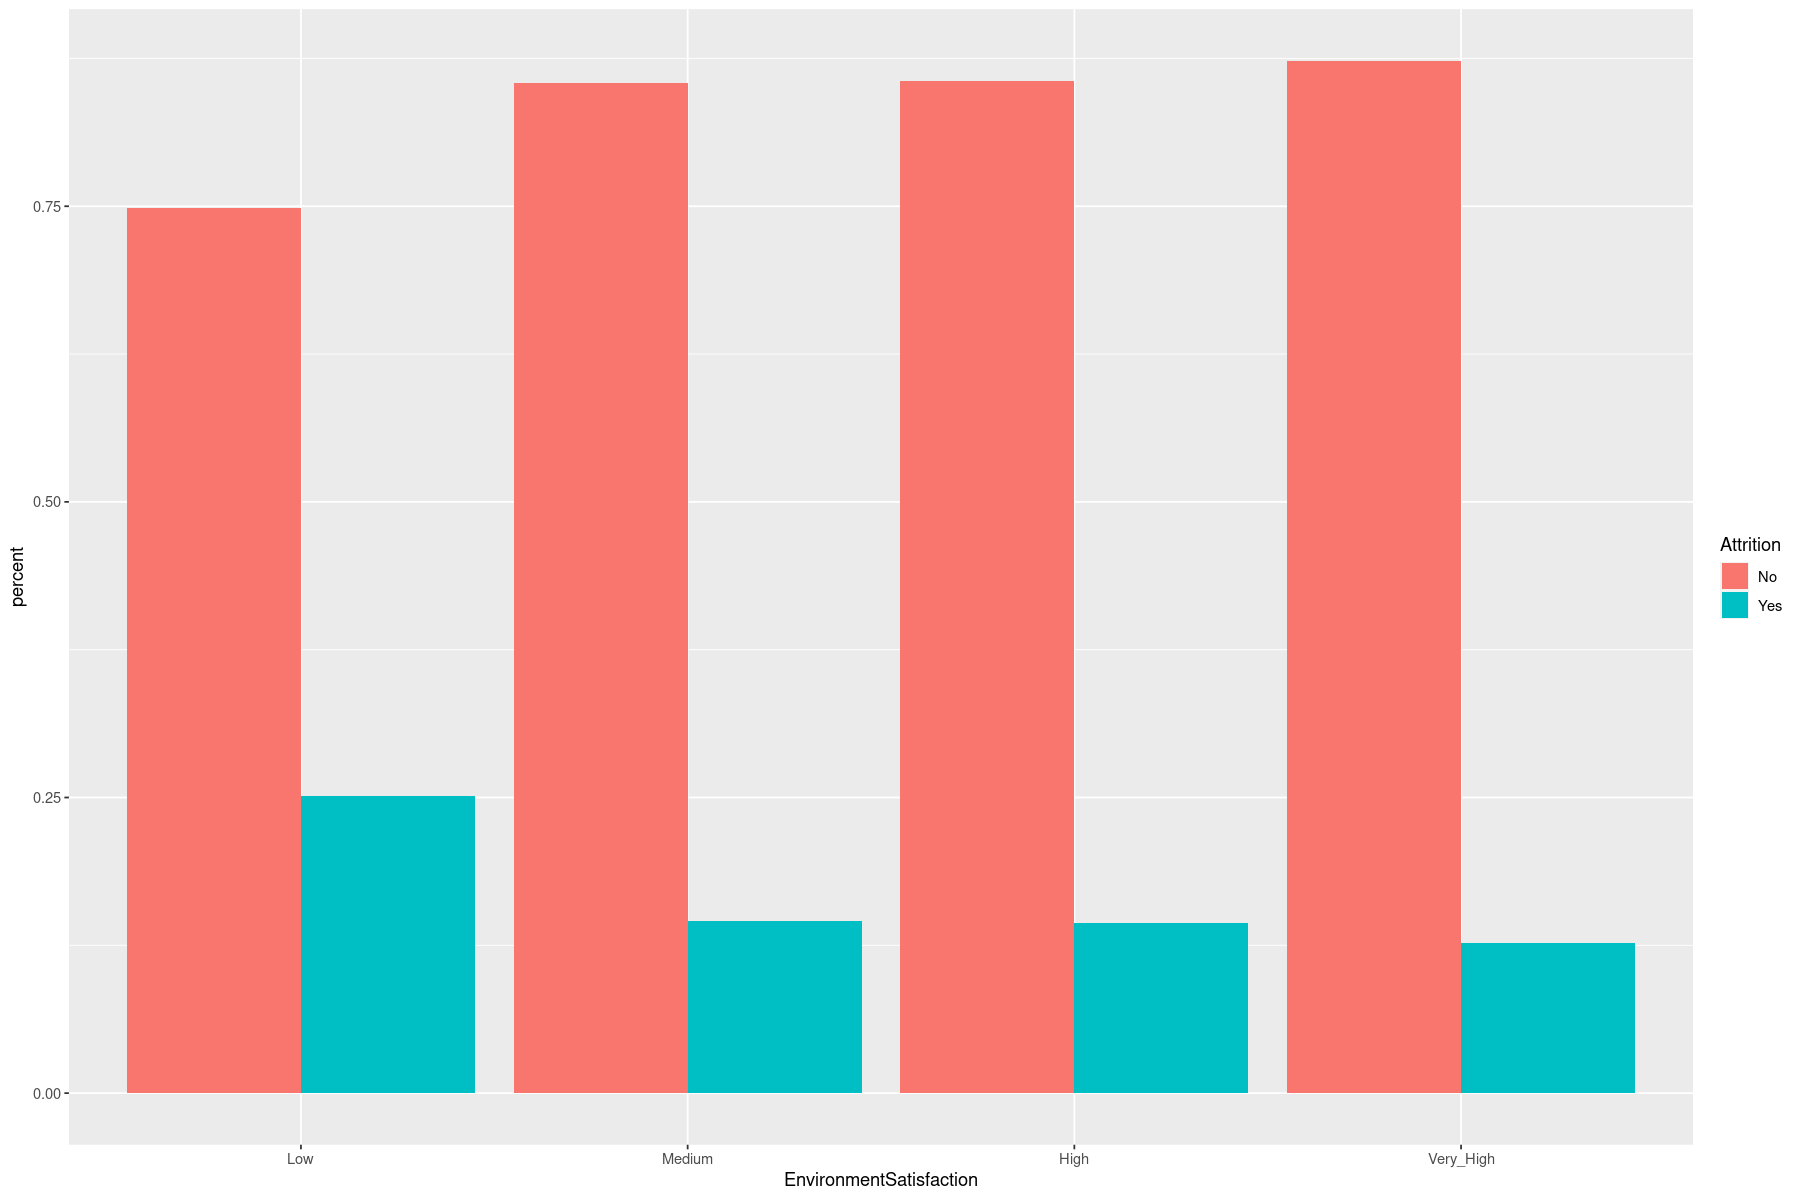

In [44]:
train_caret %>% 
    group_by(EnvironmentSatisfaction) %>% 
    count(Attrition) %>% 
    mutate(percent = n/sum(n))  %>% 
    ggplot(aes(x=EnvironmentSatisfaction, y=percent, fill=Attrition)) +
        geom_bar(stat="identity", position=position_dodge())  

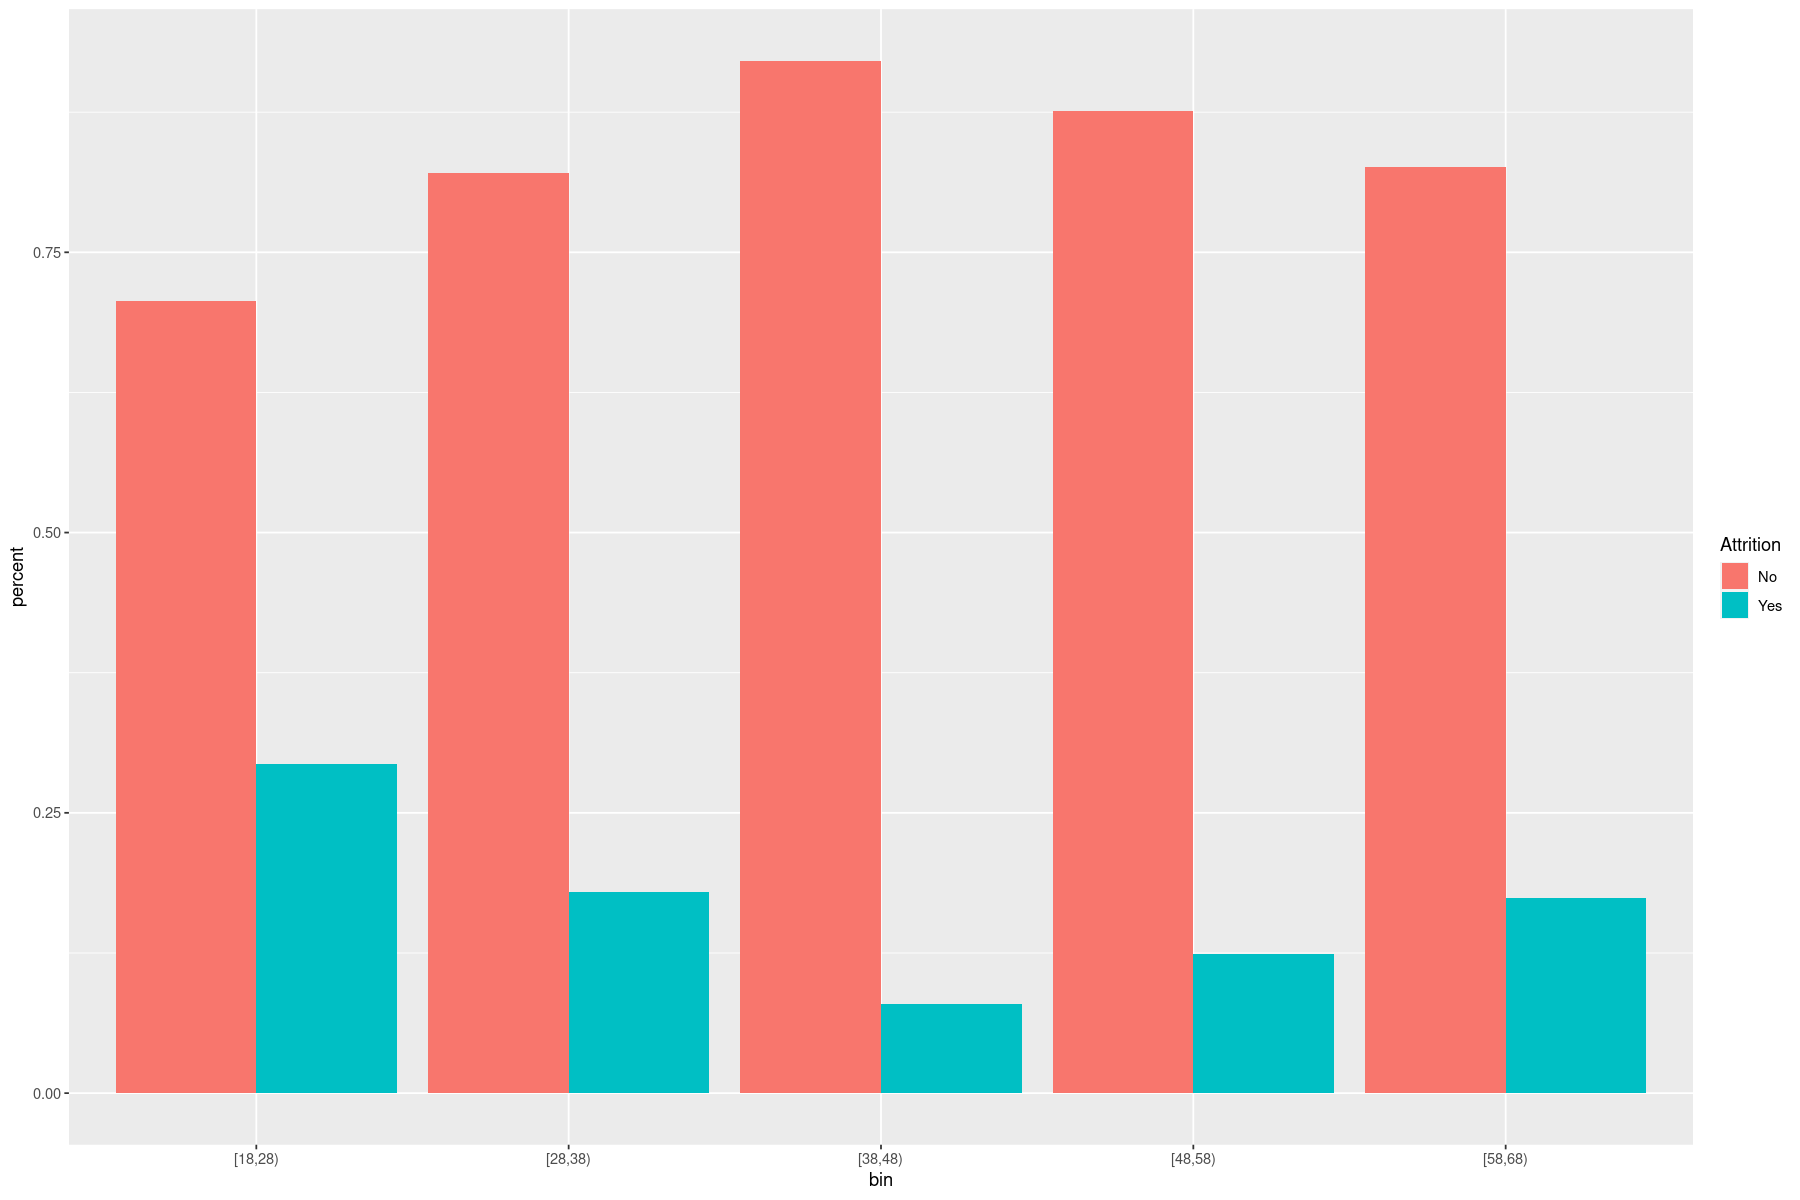

In [45]:
train_caret %>% 
    mutate(bin = cut(Age, seq(min(Age), max(Age) + 10, 10), right = FALSE))  %>% 
    group_by(bin) %>% 
    count(Attrition) %>% 
    mutate(percent = n/sum(n))  %>% 
    ggplot(aes(x=bin, y=percent, fill=Attrition)) +
        geom_bar(stat="identity", position=position_dodge())  

## Modeling

### Logistic Regression
<img src='https://static.javatpoint.com/tutorial/machine-learning/images/linear-regression-vs-logistic-regression.png'>


<img src='https://saedsayad.com/images/LogReg_1.png'>

In [46]:
lm_glm <- glm(Attrition ~ MonthlyIncome, data = train_caret, family = "binomial")
summary(lm_glm)


Call:
glm(formula = Attrition ~ MonthlyIncome, family = "binomial", 
    data = train_caret)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7699  -0.6635  -0.5835  -0.3465   2.6620  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -9.275e-01  1.551e-01  -5.979 2.24e-09 ***
MonthlyIncome -1.302e-04  2.658e-05  -4.899 9.62e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 909.69  on 1029  degrees of freedom
Residual deviance: 877.80  on 1028  degrees of freedom
AIC: 881.8

Number of Fisher Scoring iterations: 5


In [47]:
lm_caret  <- train(Attrition ~ EnvironmentSatisfaction + YearsSinceLastPromotion,
                   data = train_caret,
                   method = "glm",
                   family = "binomial")
summary(lm_caret)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7607  -0.5615  -0.5581  -0.5212   2.0323  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.6417884  0.1052667 -15.596  < 2e-16 ***
EnvironmentSatisfaction.L -0.5634162  0.1661756  -3.390 0.000698 ***
EnvironmentSatisfaction.Q  0.2639915  0.1744839   1.513 0.130283    
EnvironmentSatisfaction.C -0.1781518  0.1822308  -0.978 0.328264    
YearsSinceLastPromotion   -0.0001467  0.0268546  -0.005 0.995642    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 909.69  on 1029  degrees of freedom
Residual deviance: 894.60  on 1025  degrees of freedom
AIC: 904.6

Number of Fisher Scoring iterations: 4


### Model Evaluation
<img src="https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg">

In [48]:
pred_class <- predict(lm_caret, train_caret)

In [49]:
table(pred_class, train_caret$Attrition)

          
pred_class  No Yes
       No  864 166
       Yes   0   0

In [52]:
?caret::confusionMatrix

In [53]:
confusionMatrix(
  data = relevel(pred_class, ref = "Yes"), 
  reference = relevel(train_caret$Attrition, ref = "Yes"),
  mode='everything'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes   0   0
       No  166 864
                                          
               Accuracy : 0.8388          
                 95% CI : (0.8149, 0.8608)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.5207          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.8388          
              Precision :     NA          
                 Recall : 0.0000          
                     F1 :     NA          
             Prevalence : 0.1612          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.50

In [54]:
pred_prob = predict(lm_caret, newdata = train_caret, type = "prob")

In [55]:
head(pred_prob)

,No,Yes
,<dbl>,<dbl>
1,0.8541226,0.1458774
4,0.8729813,0.1270187
5,0.8730301,0.1269699
8,0.8730301,0.1269699
10,0.8557290,0.1442710
11,0.8729813,0.1270187


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



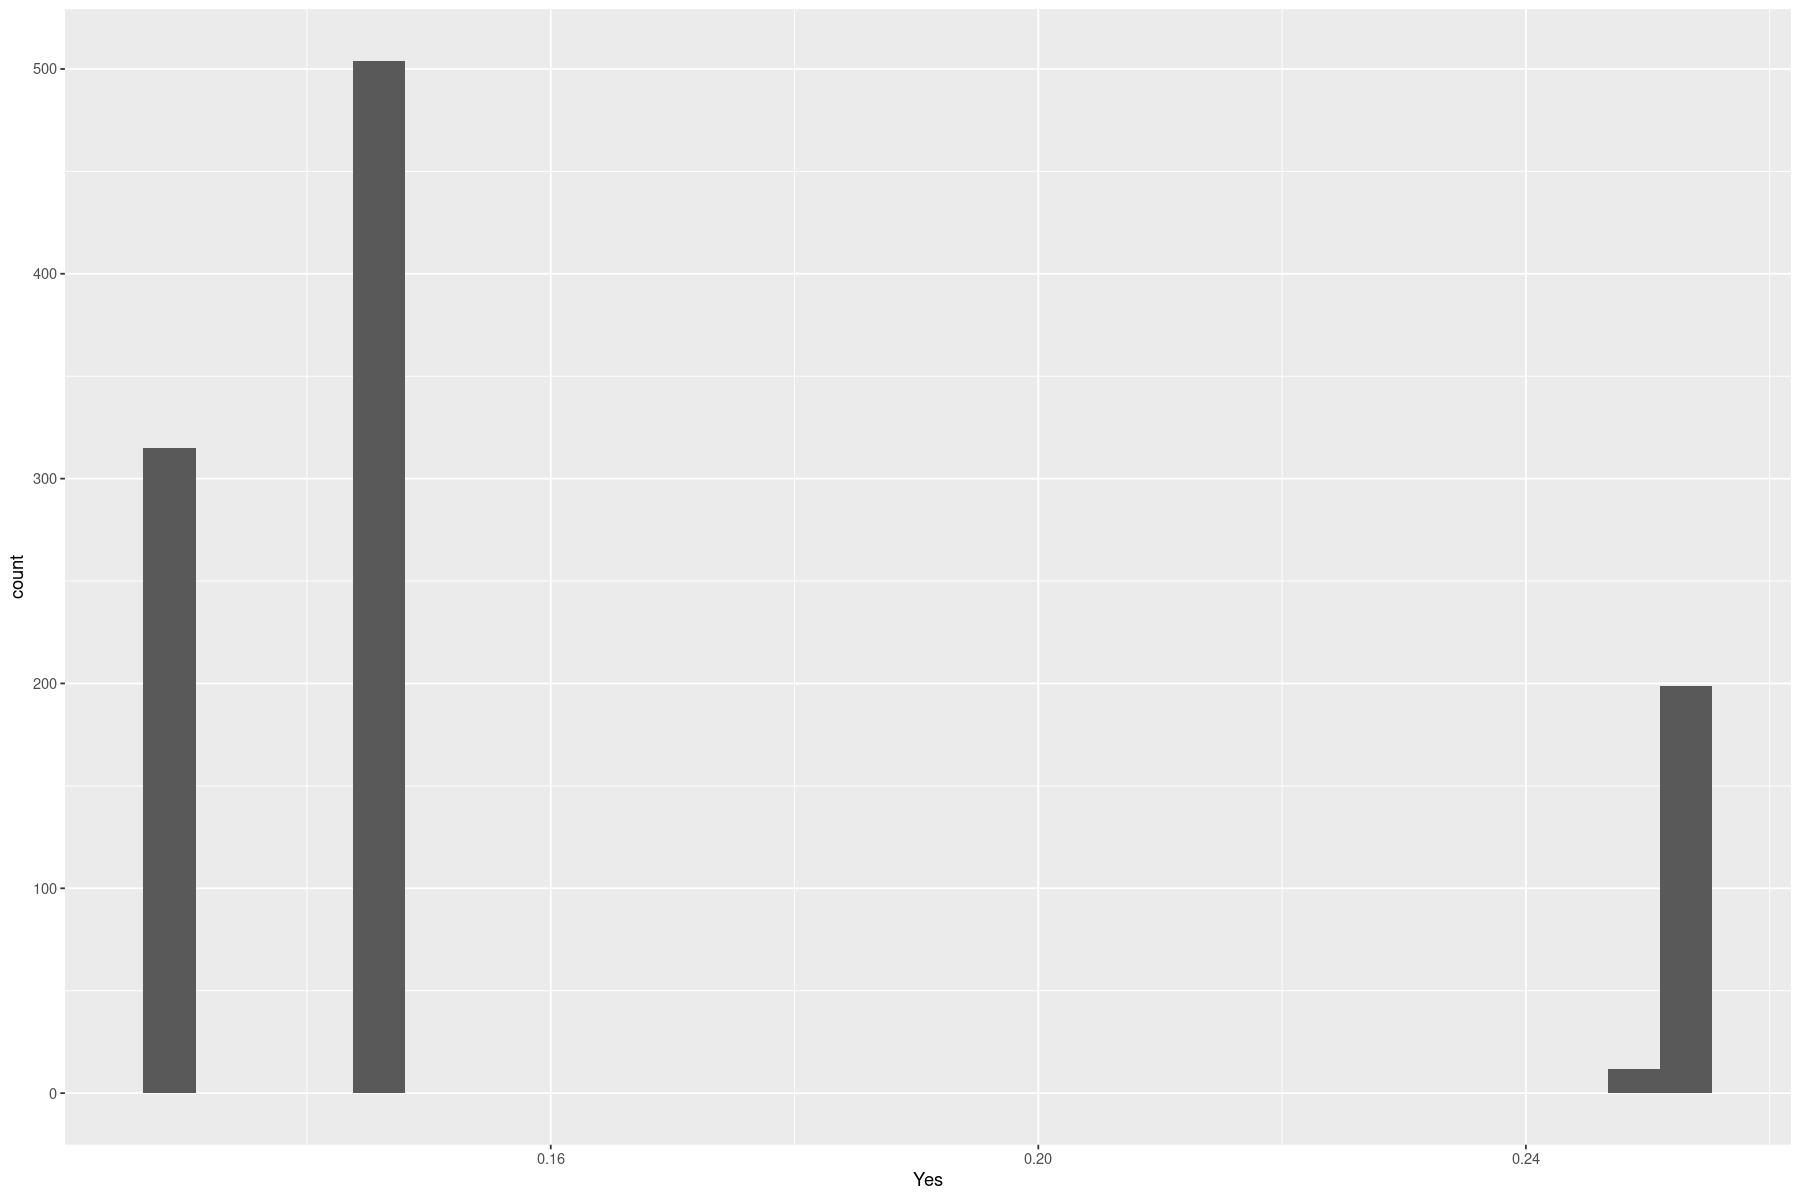

In [56]:
ggplot(pred_prob, aes(Yes) ) + geom_histogram()